# Covid19 - Brazil (Cities) Basic Graph Analysis
- by Marcelo Rovai
- 02 June 2020

## Main Libraries and setup

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly
import plotly.graph_objs as go
import bar_chart_race as bcr

In [92]:
from cv_util_func import *

In [93]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = '{:,}'.format
mpl.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-paper')


## Datasets

### Worldometers Daily Data

- Based on TDS article: [Track Coronavirus in Your Country by Displaying Notifications Using Python](https://towardsdatascience.com/coronavirus-track-coronavirus-in-your-country-by-displaying-notification-c914b5652088)

In [95]:
worldmetersLink = "https://www.worldometers.info/coronavirus/"

In [96]:
def get_wordometers_covid(country, worldmetersLink):
    today = datetime.datetime.today()
    try:
        html_page = requests.get(worldmetersLink)
    except requests.exceptions.RequestException as e:
        print(e) #ConnectionError
    bs = BeautifulSoup(html_page.content, 'html.parser')
    search = bs.select("div tbody tr td")
    start = -1
    for i in range(len(search)):
        if search[i].get_text().find(country) !=-1:
            start = i
            break
    data = []
    for i in range(1,8):
        try:
            data = data + [search[start+i].get_text()]
        except:
            data = data + ["0"]

    data = data_cleanup(data)

    print('\n{} - Worldometers Daily Data\n'.format(country))
    print(
        "Today is {} \n- Total infected = {} \n- New Cases = {} \n- Total Deaths = {} \n- New Deaths = {} \n- Recovered = {} \n- Active Cases = {} \n- Serious-Critical = {}"
        .format(today, *data))
    return data, today



In [98]:
data_wd_covid_br, today = get_wordometers_covid('World', worldmetersLink)
# Saving Brazil info
Total_infected = data_wd_covid_br[0]
New_Cases = data_wd_covid_br[1]
Total_Deaths = data_wd_covid_br[2]
New_Deaths = data_wd_covid_br[3] 
Recovred = data_wd_covid_br[4] 
Active_Case = data_wd_covid_br[5] 
Serious_Critical = data_wd_covid_br[6]
date = today


World - Worldometers Daily Data

Today is 2020-11-21 15:32:11.516656 
- Total infected = 58.274.052 
- New Cases = 375.057 
- Total Deaths = 1.383.551 
- New Deaths = 6.694 
- Recovered = 40.357.103 
- Active Cases = 257.489 
- Serious-Critical = 16.533.398


In [97]:
data_wd_covid_br, today = get_wordometers_covid('Brazil', worldmetersLink)
# Saving Brazil info
Total_infected = data_wd_covid_br[0]
New_Cases = data_wd_covid_br[1]
Total_Deaths = data_wd_covid_br[2]
New_Deaths = data_wd_covid_br[3] 
Recovred = data_wd_covid_br[4] 
Active_Case = data_wd_covid_br[5] 
Serious_Critical = data_wd_covid_br[6]
date = today


Brazil - Worldometers Daily Data

Today is 2020-11-21 15:29:13.045730 
- Total infected = 6.020.164 
- New Cases = 0 
- Total Deaths = 168.687 
- New Deaths = 25 
- Recovered = 5.422.102 
- Active Cases = 0 
- Serious-Critical = 429.375


In [99]:
def plot_wm_table(country, worldmetersLink, show=False, save=True):
    data_wm, today = get_wordometers_covid(country, worldmetersLink)
    wm_date = str(today.year)+'/'+ str(today.month) +'/'+ str(today.day) +' - '+str(today.hour)+'h'
    wm = ['Total_infected', 'New_Cases', 'Total_Deaths', 'New_Deaths', 'Recovered', 'Serious_Critical' , 'Mild Condition']

    fig = go.Figure(data=[
        go.Table(header=dict(values=['Wordometers', 'Data'],
                             fill_color='#D6D6D6',
                             align=['center', 'center'],
                             font=dict(color='green', size=16)),
                 cells=dict(
                     values=[wm, data_wm],
                     fill_color="#E5ECF6",
                     align=['center', 'center'],
                     font=dict(color='firebrick', size=15),
                     height=30))
    ])
    fig.update_layout(
        title='{} Wordometer Data - {}'.format(country, wm_date),
        font=dict(size=14, color="#7f7f7f"),
        margin=dict(l=20, r=20, t=50, b=20),
        autosize=False,
        width=600,
        height=310,
        )

    if save == True:
        fig.write_image('../graphs/wm_'+country+'_table.png')
    if show == True:
        fig.show()

### Covid19

Confirmed cases by day, using information from the news. Covid19br dataset is available at GitHub https://github.com/wcota/covid19br, with data by city compiled from original dataset provided by [Brasil.IO](https://brasil.io/dataset/covid19/caso/). <br>
Thanks to: 
- [Wesley Cota](https://wesleycota.com), PhD candidate - Complex Networks/Physics (Universidade Federal de Viçosa - Brazil and Universidad de Zaragoza - Spain) 
- [Alvaro Justen](https://blog.brasil.io/author/alvaro-justen.html) from [Brasil.IO](https://brasil.io/dataset/covid19/caso/).

License: [Creative Commons Attribution-ShareAlike 4.0 International (CC BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/)

More information: https://wcota.me/covid19br and [ESPECIAL COVID-19 - Dados por Município](https://brasil.io/covid19/)

**Number of total cases by city** 

In [7]:
def get_brazil_cv_data(date, save=True):

    url = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities.csv'
    url_st = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'
    url_tm = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv.gz'
    dt = pd.read_csv(url, error_bad_lines=False)
    dt_st = pd.read_csv(url_st, error_bad_lines=False)
    dt_tm = pd.read_csv(url_tm, compression='gzip', error_bad_lines=False)
    print("\nToday is {}/{}/{}. Dataset with {} observations.\n".format(
        date.year, date.month, date.day, dt.shape[0]))

    file = '../data/cases-brazil-cities-'+str(date.day)+'-'+str(date.month)+'-'+str(date.year)+'.csv'
    if save == True:
        dt.to_csv(file)

    dt.rename(columns={'ibgeID':'COD. IBGE'}, inplace=True)
    total_cases = dt.totalCases.sum()
    deaths = dt.deaths.sum()
    cfr = round ((deaths/total_cases)*100, 2)
    print('\nTotal number of cases in Brasil at {}/{}: {:,} ({} fatal) with a CFR of {}%'.format(
    date.month, date.day, total_cases, deaths, cfr))
    dt['CFR[%]'] = round((dt.deaths/dt.totalCases)*100, 2)
    dt.fillna(0, inplace=True)

    dt_state = dt.groupby('state')[['deaths','totalCases']].sum().reset_index()
    dt_state['CFR[%]'] = round((dt_state.deaths/dt_state.totalCases)*100, 2)

    dt_tm_city = dt_tm.loc[(dt_tm['state'] != 'TOTAL')].copy()
    dt_tm_city.rename(columns={'ibgeID':'COD. IBGE'}, inplace=True)

    return dt, dt_st, dt_tm, dt_tm_city, dt_state, total_cases, deaths, cfr

In [8]:
today = datetime.datetime.today()

In [103]:
dt, dt_st, dt_tm, dt_tm_city, dt_state, total_cases, deaths, cfr = get_brazil_cv_data(
    today, save=False)


Today is 2020/11/21. Dataset with 5595 observations.


Total number of cases in Brasil at 11/21: 6,023,623 (168724 fatal) with a CFR of 2.8%


In [10]:
dt_tm.head(2)

epi_week        date country  state          city   ibgeID  \
0         9  2020-02-25  Brazil     SP  São Paulo/SP  3550308   
1         9  2020-02-25  Brazil  TOTAL         TOTAL        0   

   cod_RegiaoDeSaude name_RegiaoDeSaude  newDeaths  deaths  newCases  \
0           35,016.0          São Paulo          0       0         1   
1                nan                NaN          0       0         1   

   totalCases  deaths_per_100k_inhabitants  totalCases_per_100k_inhabitants  \
0           1                          0.0                          0.00811   
1           1                          0.0           0.00047000000000000004   

   deaths_by_totalCases _source last_info_date  
0                   0.0     SES     2020-11-18  
1                   0.0     NaN            NaN

In [104]:
dt_tm.tail()

epi_week        date country  state              city   ibgeID  \
1083708        47  2020-11-20  Brazil     PR         Ângulo/PR  4101150   
1083709        47  2020-11-20  Brazil     BA  Érico Cardoso/BA  2900504   
1083710        47  2020-11-20  Brazil     PA         Óbidos/PA  1505106   
1083711        47  2020-11-20  Brazil     SP           Óleo/SP  3533809   
1083712        47  2020-11-20  Brazil  TOTAL             TOTAL        0   

         cod_RegiaoDeSaude name_RegiaoDeSaude  newDeaths  deaths  newCases  \
1083708           41,015.0     15ª RS Maringá          0       1         0   
1083709           29,003.0            Brumado          0       1         5   
1083710           15,002.0     Baixo Amazonas          0      47         0   
1083711           35,094.0           Ourinhos          0       0         0   
1083712                nan                NaN        506  168724     36480   

         totalCases  deaths_per_100k_inhabitants  \
1083708          64           34.129690000000004   
1083709          13                       9.4697   
1083710        2970                     89.85585   
1083711           6                          0.0   
1083712     6023623            79.67860999999999   

         totalCases_per_100k_inhabitants  deaths_by_totalCases _source  \
1083708                      2,184.30034  0.015619999999999998      MS   
1083709               123.10606000000001               0.07692      MS   
1083710               5,678.124879999999  0.015819999999999997      MS   
1083711               242.81667000000002                   0.0      MS   
1083712                      2,844.60972  0.028010000000000004     NaN   

        last_info_date  
1083708     2020-11-20  
1083709     2020-11-20  
1083710     2020-11-20  
1083711     2020-11-20  
1083712            NaN

## Plot a Resumen Tables

### Worldometer

In [100]:
plot_wm_table('World', worldmetersLink, show=True, save=False)


World - Worldometers Daily Data

Today is 2020-11-21 15:38:59.718426 
- Total infected = 58.274.288 
- New Cases = 375.293 
- Total Deaths = 1.383.551 
- New Deaths = 6.694 
- Recovered = 40.357.167 
- Active Cases = 257.553 
- Serious-Critical = 16.533.570


In [101]:
plot_wm_table('South America', worldmetersLink, show=True, save=False)


South America - Worldometers Daily Data

Today is 2020-11-21 15:39:16.070745 
- Total infected = 10.625.450 
- New Cases = 1.683 
- Total Deaths = 315.826 
- New Deaths = 63 
- Recovered = 9.576.975 
- Active Cases = 1.995 
- Serious-Critical = 732.649


In [102]:
plot_wm_table('Brazil', worldmetersLink, show=True, save=False)


Brazil - Worldometers Daily Data

Today is 2020-11-21 15:39:27.735729 
- Total infected = 6.020.164 
- New Cases = 0 
- Total Deaths = 168.687 
- New Deaths = 25 
- Recovered = 5.422.102 
- Active Cases = 0 
- Serious-Critical = 429.375


### GeoData Table

In [15]:
br_shp, br_cities = load_geodata()

Number of Brazilian Cities: 5,570
Total Brazilian Population: 210,147,125
Total Brazilian Territory : 8,985,590.0 km2 (aprox.)
Average Demografic Density : 23.0 hab/km2 (aprox.)


In [16]:
cv_city, deaths_city, cv_city_pnt, deaths_city_pnt, total_cases, deaths, cfr, number_cities_cases, number_cities_deaths = get_Brazil_data(
    dt, br_shp, br_cities)

Brazil: Total number of Covid19 cases at 11/20: 5,985,684 (168,194 fatal) in 5,570 cities with a CFR of 2.81%


In [17]:
perc_cases = round((number_cities_cases/5570)*100, 0)
perc_deaths = round((number_cities_deaths/5570)*100, 0)

In [18]:
geo = [
    'Total number of Cases', 'Total number of Deaths', 'CFR [%]',
    'Total number of Brazil cities', 'Number of Identified cities with cases',
    'Brazilian cities with cases [%]',
    'Number of Identified cities with deaths',
    'Brazilian cities with deaths [%]'
]
data_geo = [
    total_cases, deaths, cfr, 5570, number_cities_cases, perc_cases,
    number_cities_deaths, perc_deaths
]

In [19]:
def plot_geo_table(today, geo, data_geo, show=False, save=True):
    
    
    geo_date = str(today.year)+'/'+ str(today.month) +'/'+ str(today.day) +' - '+str(today.hour)+'h'
    #wm = ['Total_infected', 'New_Cases', 'Total_Deaths', 'New_Deaths', 'Recovered', 'Active_Case' , 'Serious_Critical']

    fig = go.Figure(data=[
        go.Table(header=dict(values=['Geo Summary', 'Brazil Data'],
                             fill_color='#D6D6D6',
                             align=['center', 'center'],
                             font=dict(color='green', size=16)),
                 cells=dict(
                     values=[geo, data_geo],
                     fill_color="#E5ECF6",
                     align=['right', 'center'],
                     font=dict(color='firebrick', size=15),
                     format = [None, ","],
                     height=30))
    ])
    fig.update_layout(
        title='Brazil Geo Data summary - {}'.format(geo_date),
        font=dict(size=16, color="#7f7f7f"),
        margin=dict(l=20, r=20, t=50, b=20),
        autosize=False,
        width=700,
        height=350,
        )

    if save == True:
        fig.write_image('../graphs/geo_table.png')
    if show == True:
        fig.show()

In [20]:
plot_geo_table(today, geo, data_geo, show=True, save=False)

### Total cases by state

In [21]:
dt_st = dt_st.fillna(0)
dt_st['recovered'] = dt_st['recovered'].astype('int64')
dt_st['suspects'] = dt_st['suspects'].astype('int64')
dt_st['tests'] = dt_st['tests'].astype('int64')

In [22]:
date_today = list(dt_st.date[-2:-1])[0]
dt_st_today = dt_st[dt_st.date == date_today]
dt_st_today.shape

(28, 18)

In [23]:
def plot_table(dx, show=False, save=True):
    date = datetime.datetime.today()
    
    data = [dx.state, dx.recovered, dx.deaths, dx.totalCases, dx.suspects, dx.tests]
    labels = ['State', 'Recovered', 'Deaths', 'Total Cases', 'Suspects', 'Tests']

    fig = go.Figure(data=[
        go.Table(header=dict(values=labels,
                             fill_color='#D6D6D6',
                             align=['center', 'center'],
                             font=dict(color='green', size=16)),
                 cells=dict(
                     values=data,
                     fill_color="#E5ECF6",
                     align=['center', 'center'],
                     font=dict(color='firebrick', size=15),
                     format = [None, ","],
                     height=30))
    ])
    fig.update_layout(
        title='Brazil Covid-19 - Data by States - {}/{}/{} - {}h'.format(
            date.year,
            date.month,
            date.day,
            date.hour
        ),
        font=dict(size=16, color="#7f7f7f"),
        margin=dict(l=20, r=20, t=50, b=20),
        autosize=False,
        width=600,
        height=1000,
        annotations=[
            dict(x=1,
                 y=0,
                 text="Source: https://github.com/wcota/covid19br/blob/master/cases-brazil-states.csv",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='bottom',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue')),
            dict(x=1,
                 y=0.015,
                 text="Created by Marcelo Rovai - https://MJRoBot.org",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='bottom',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue'))
        ])

    if save == True:
        fig.write_image('../graphs/state_table.png')
    if show == True:
        fig.show()

In [24]:
dx = dt_st_today.sort_values('deaths', ascending=False)
plot_table(dx, show=True, save=False)

## State Maps

In [25]:
def plot_state_map(state, feature):

    date = datetime.datetime.today()
    ax = state.plot(column=feature,
                    cmap='YlOrRd',
                    scheme='quantiles',
                    legend=True,
                    figsize=(18, 16),
                    edgecolor='gray',
                    linewidth=1)
    plt.title("Covid-19 - {} per State".format(feature.capitalize()),
              fontsize=20, loc='center')
    ax.set_axis_off()
    for idx, row in state.iterrows():
        plt.annotate(s=row['UF'],
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center',
                     fontsize=15,
                     color='gray')

    plt.annotate('Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
        date.year, date.month, date.day),
        xy=(0.55, .17),
        xycoords='figure fraction',
        horizontalalignment='left',
        fontsize=12,
        color='blue')
    plt.annotate('Source: https://github.com/wcota/covid19br/blob/master/cases-brazil-states.csv',
                 xy=(0.55, .16),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate(
        'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/',
        xy=(0.55, .15),
        xycoords='figure fraction',
        horizontalalignment='left',
        fontsize=12,
        color='blue')
    
    file_today = '../images/!cv19_BR_states_'+feature+'.png'
    plt.savefig(file_today, dpi=300)

In [26]:
state = dt_st_today.copy()
state.rename(columns={'state':'UF'}, inplace = True)
state.head()

epi_week        date country  UF   city  newDeaths  deaths  newCases  \
7042        47  2020-11-19  Brazil  AC  TOTAL          1     710       251   
7043        47  2020-11-19  Brazil  AL  TOTAL          4    2308       172   
7044        47  2020-11-19  Brazil  AM  TOTAL         13    4741       957   
7045        47  2020-11-19  Brazil  AP  TOTAL          2     785       233   
7046        47  2020-11-19  Brazil  BA  TOTAL         25    8038      2849   

      totalCases  deathsMS  totalCasesMS  deaths_per_100k_inhabitants  \
7042       33976       710         33976                      80.5048   
7043       93123      2308         93123                     69.15652   
7044      172118      4741        172118                    114.38989   
7045       55885       785         55885                     92.81911   
7046      380294      8038        380294                     54.04401   

      totalCases_per_100k_inhabitants  deaths_by_totalCases  recovered  \
7042                       3,852.4381                0.0209      29774   
7043                       2,790.3218               0.02478      89781   
7044                      4,152.82837               0.02755     147310   
7045                      6,607.89305               0.01405      45963   
7046                      2,556.93111               0.02114     364146   

      suspects    tests  tests_per_100k_inhabitants  
7042         0    92474         10,485.353229999999  
7043         0   204240         6,119.8127700000005  
7044         0   434271                10,478.00305  
7045         0    99790                11,799.26005  
7046         0  1517052                10,199.99645

In [27]:
state = pd.merge(br_shp, state, on='UF')
state.shape

(27, 27)

In [28]:
state.columns

Index(['ID', 'COD. UF', 'NM_ESTADO', 'NM_REGIAO', 'UF', 'QTD_MUN', 'POP_2019',
       'AREA_APROX', 'DENS_DEMOG', 'geometry', 'epi_week', 'date', 'country',
       'city', 'newDeaths', 'deaths', 'newCases', 'totalCases', 'deathsMS',
       'totalCasesMS', 'deaths_per_100k_inhabitants',
       'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'recovered',
       'suspects', 'tests', 'tests_per_100k_inhabitants'],
      dtype='object')

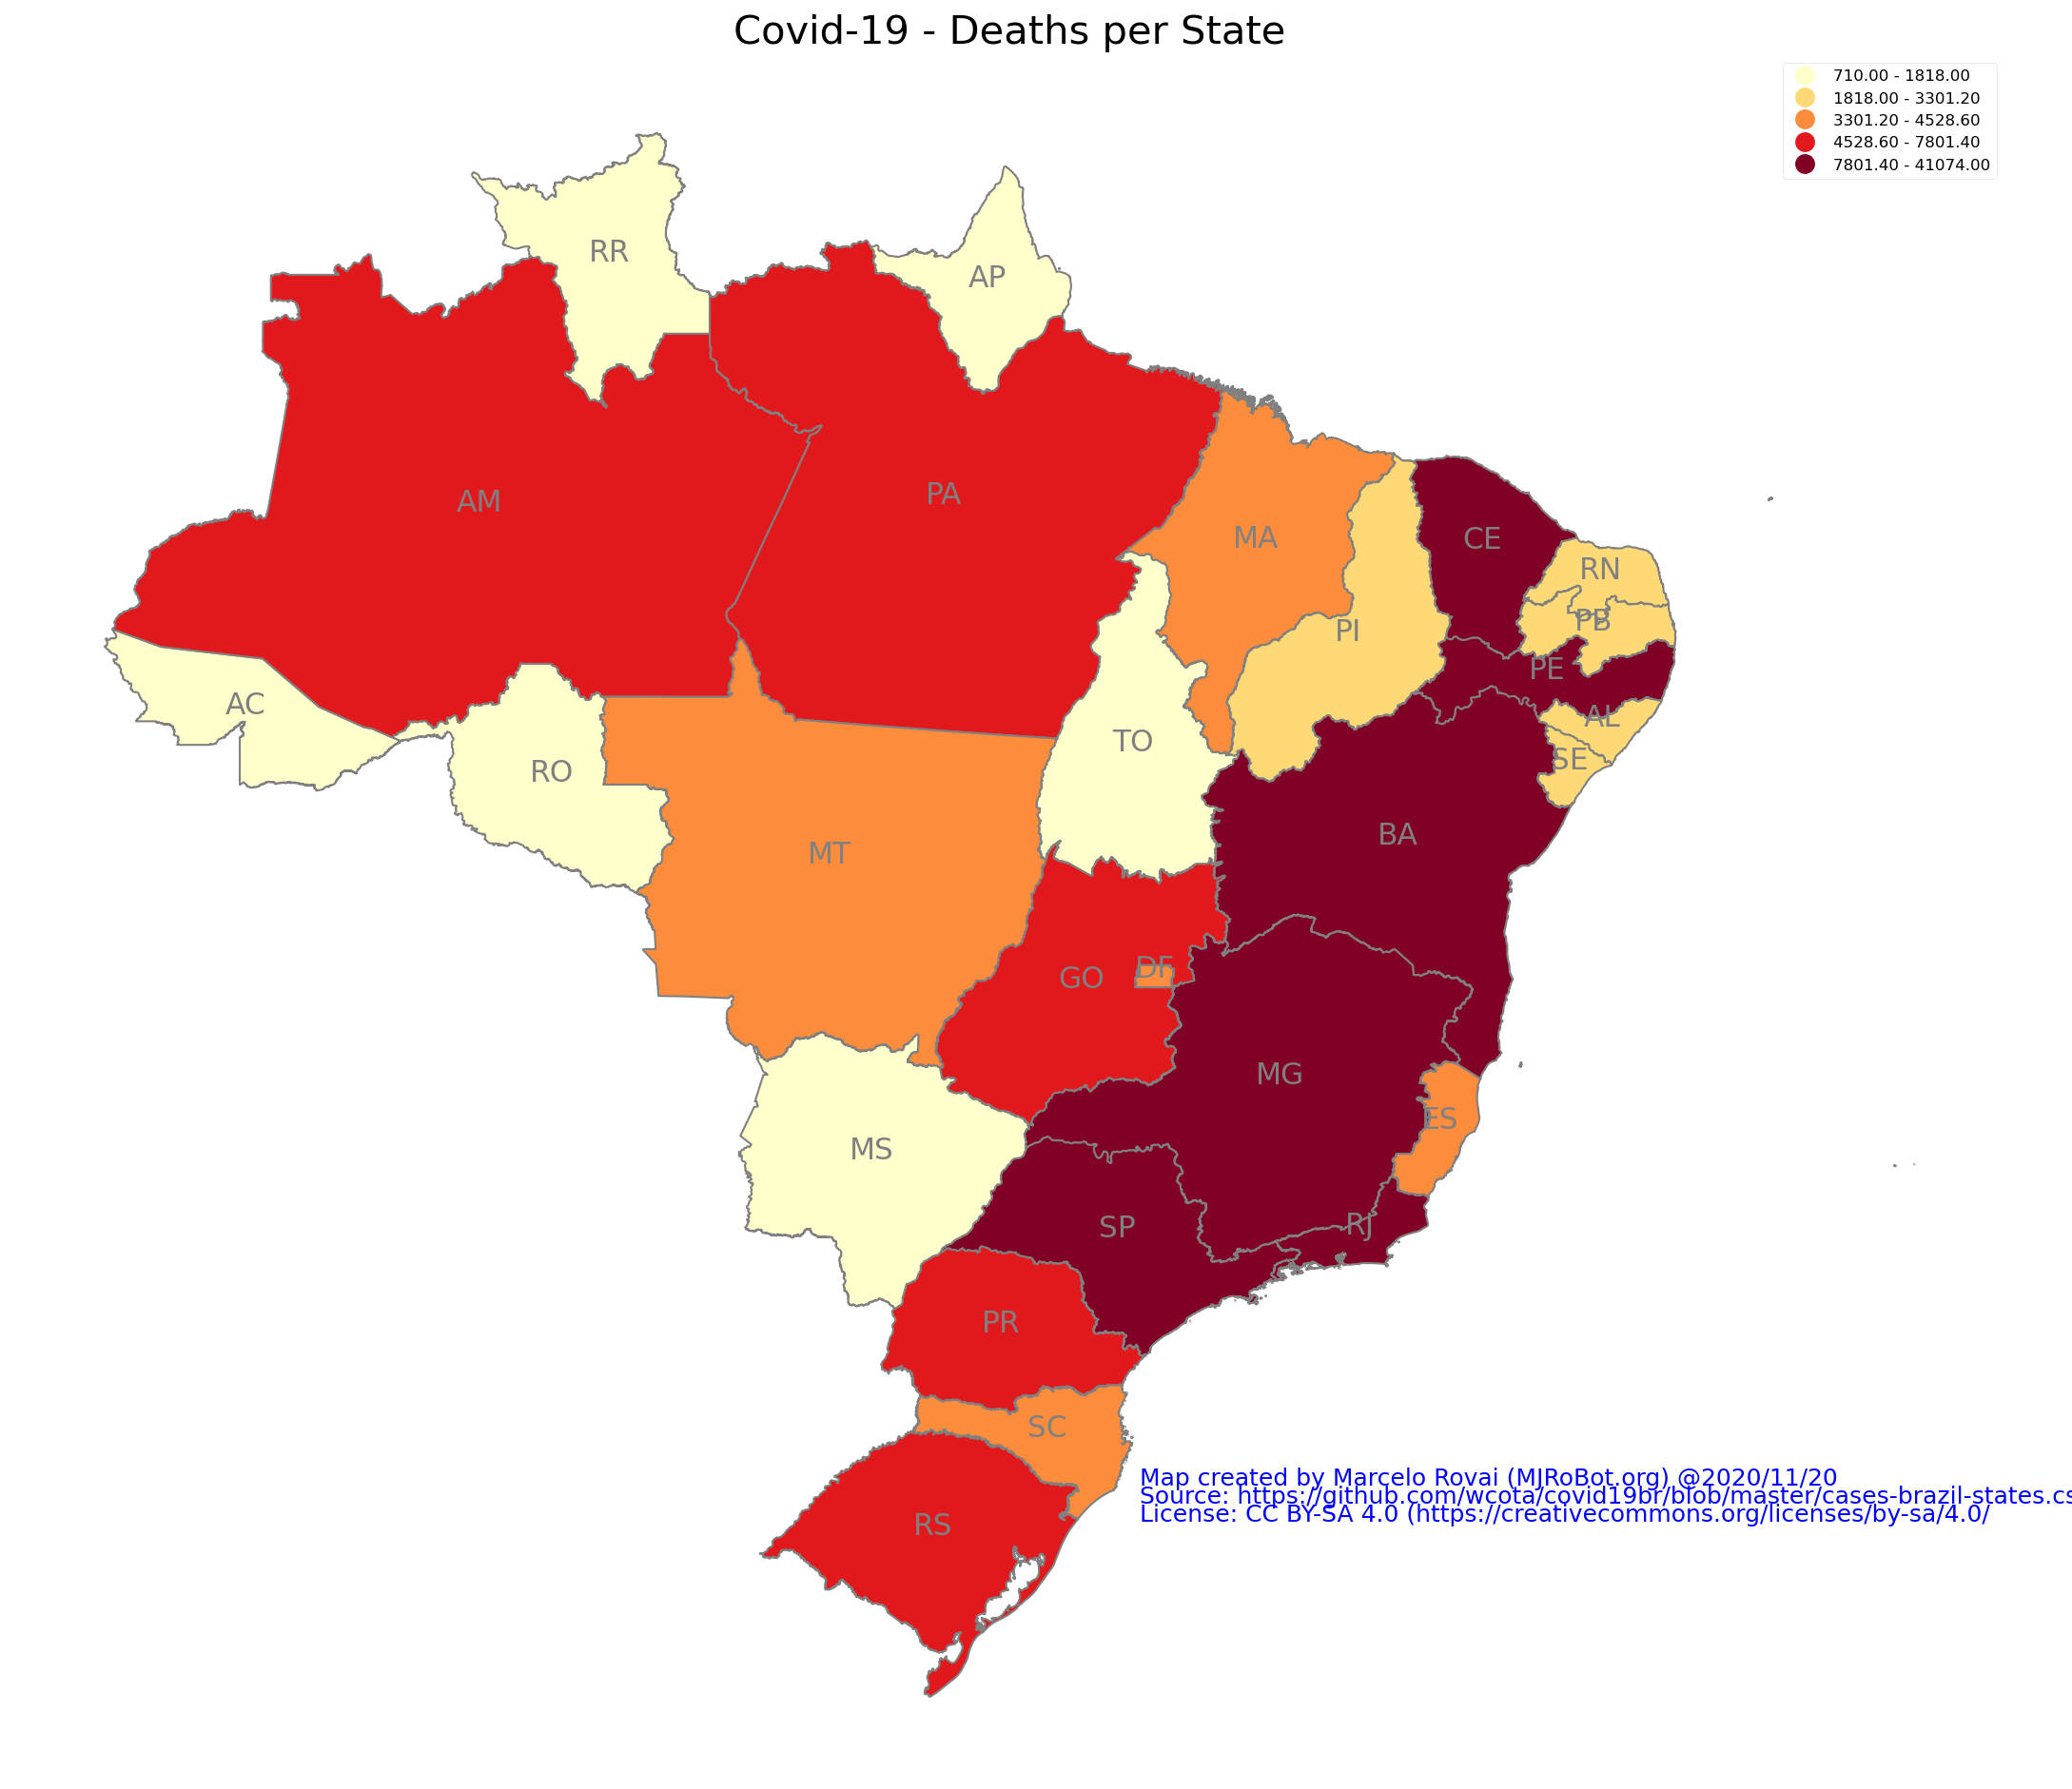

In [29]:
plot_state_map(state, 'deaths')

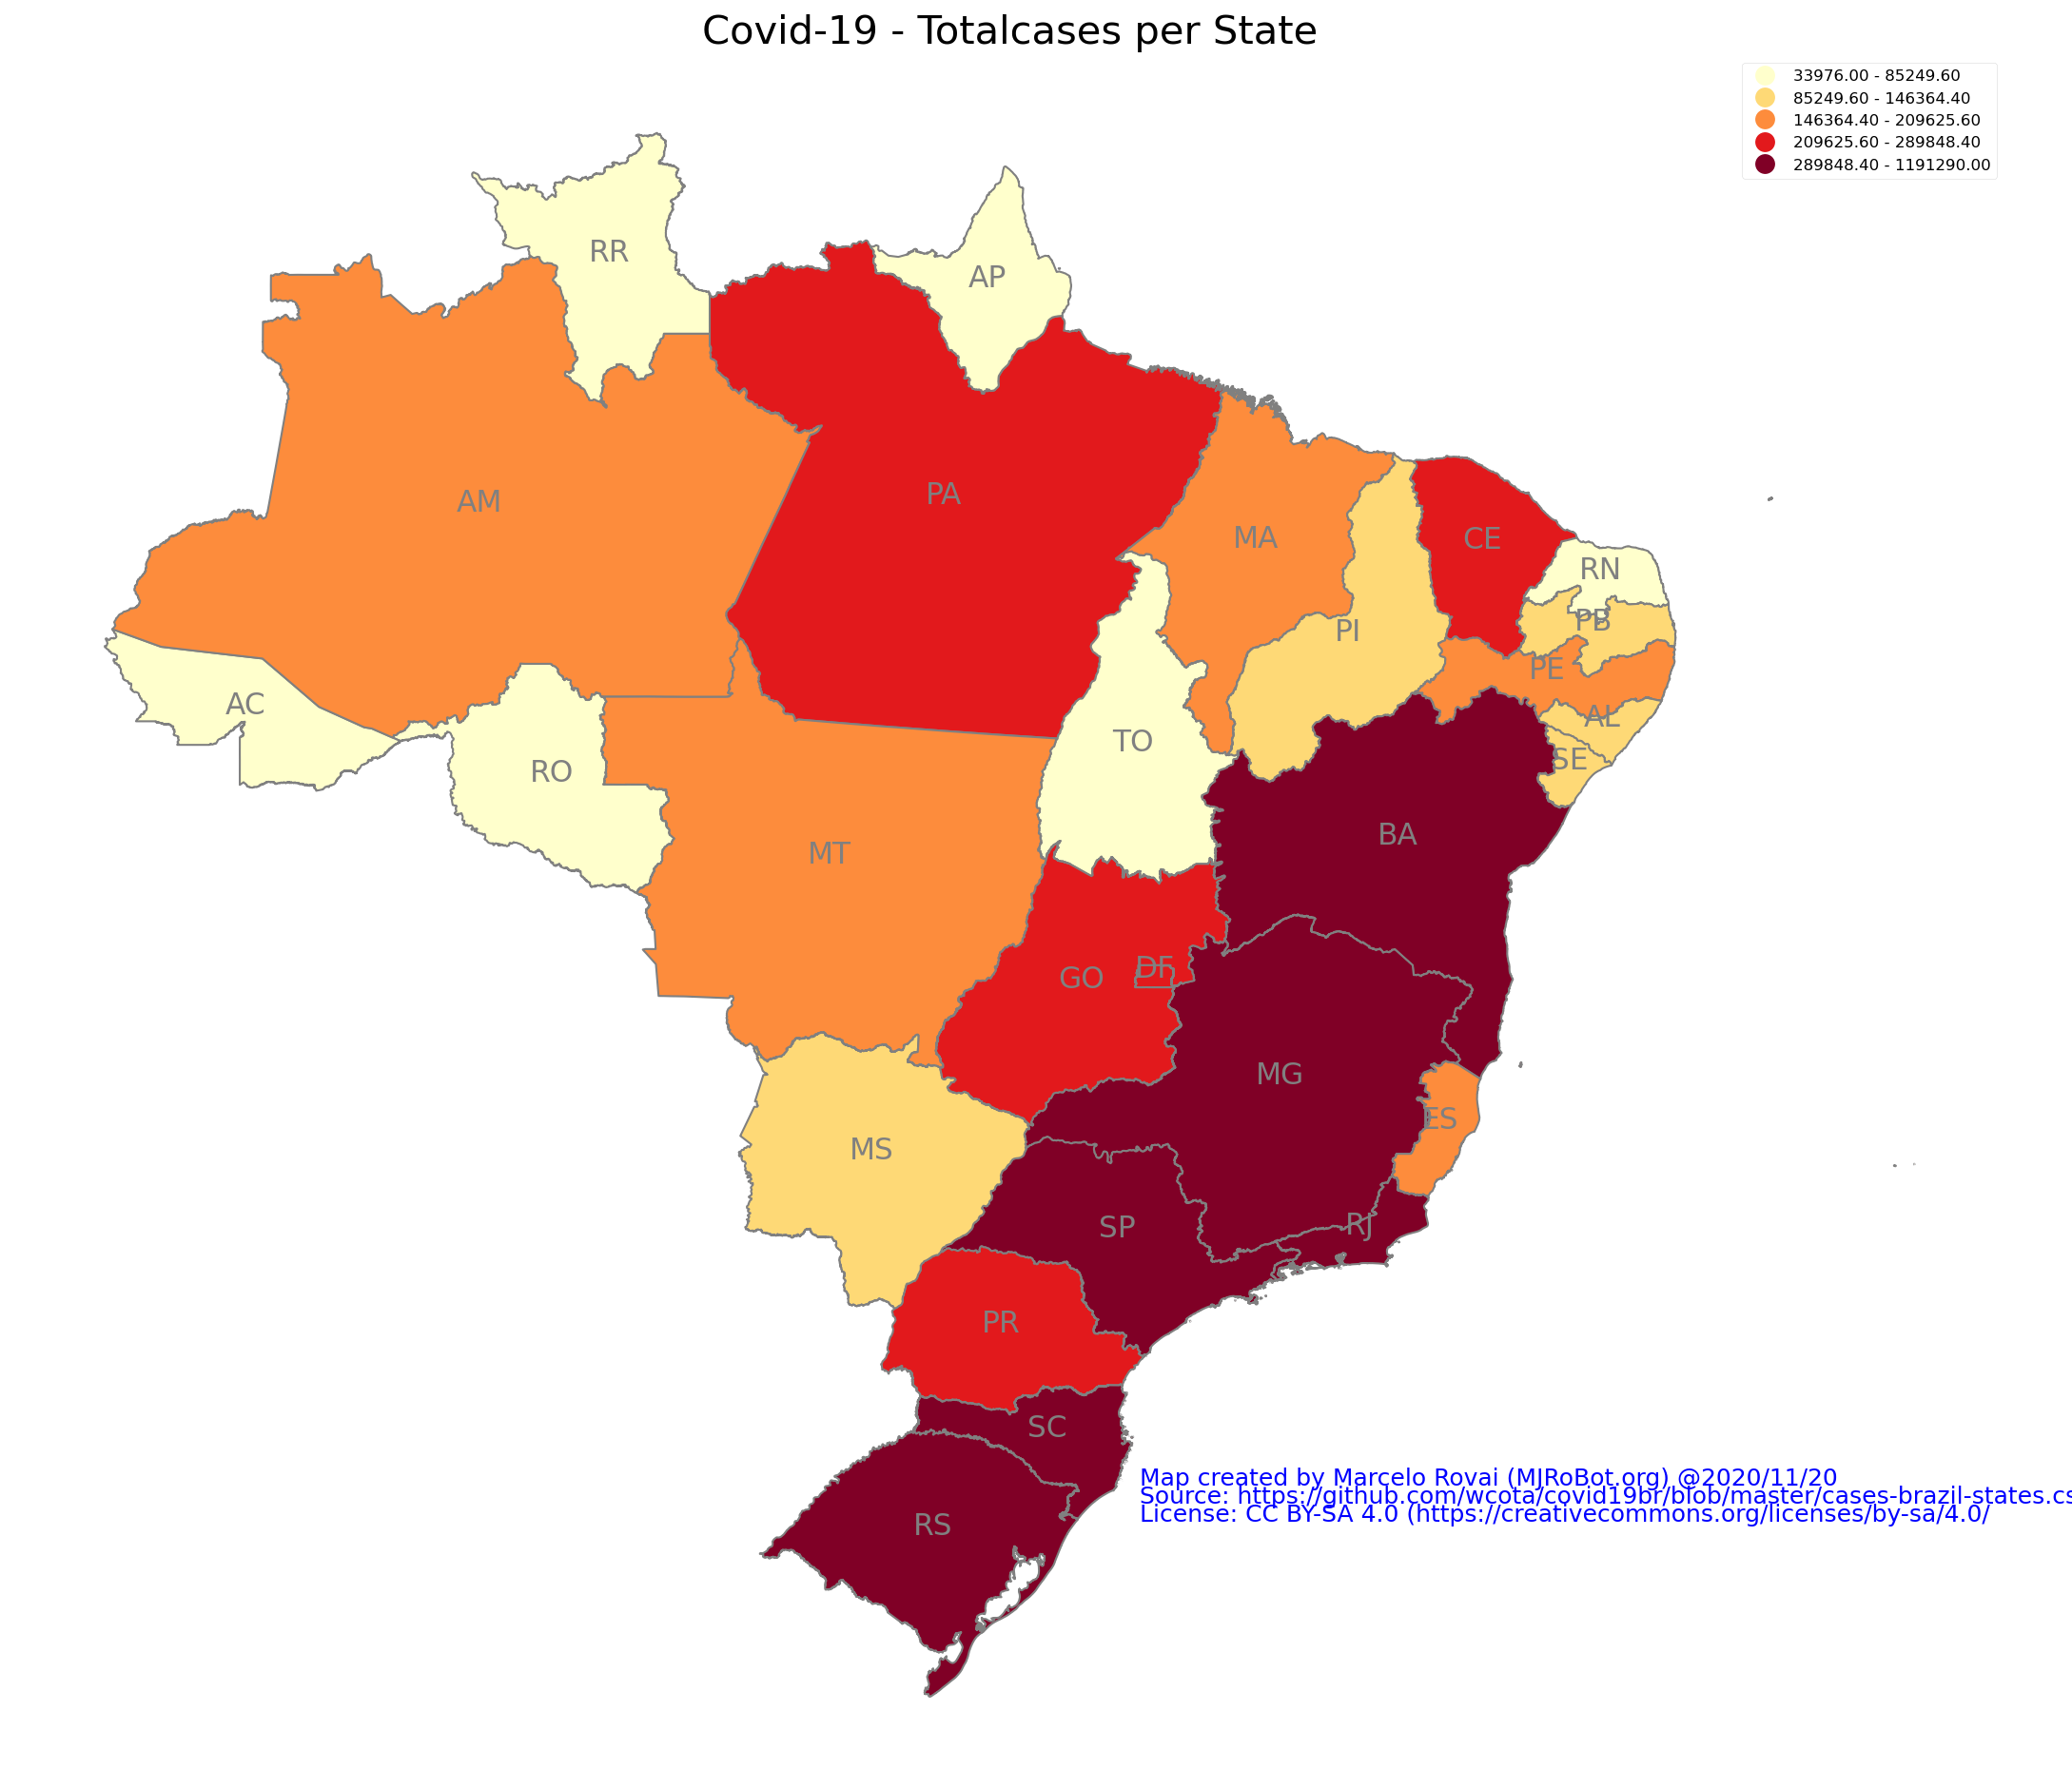

In [30]:
plot_state_map(state, 'totalCases')

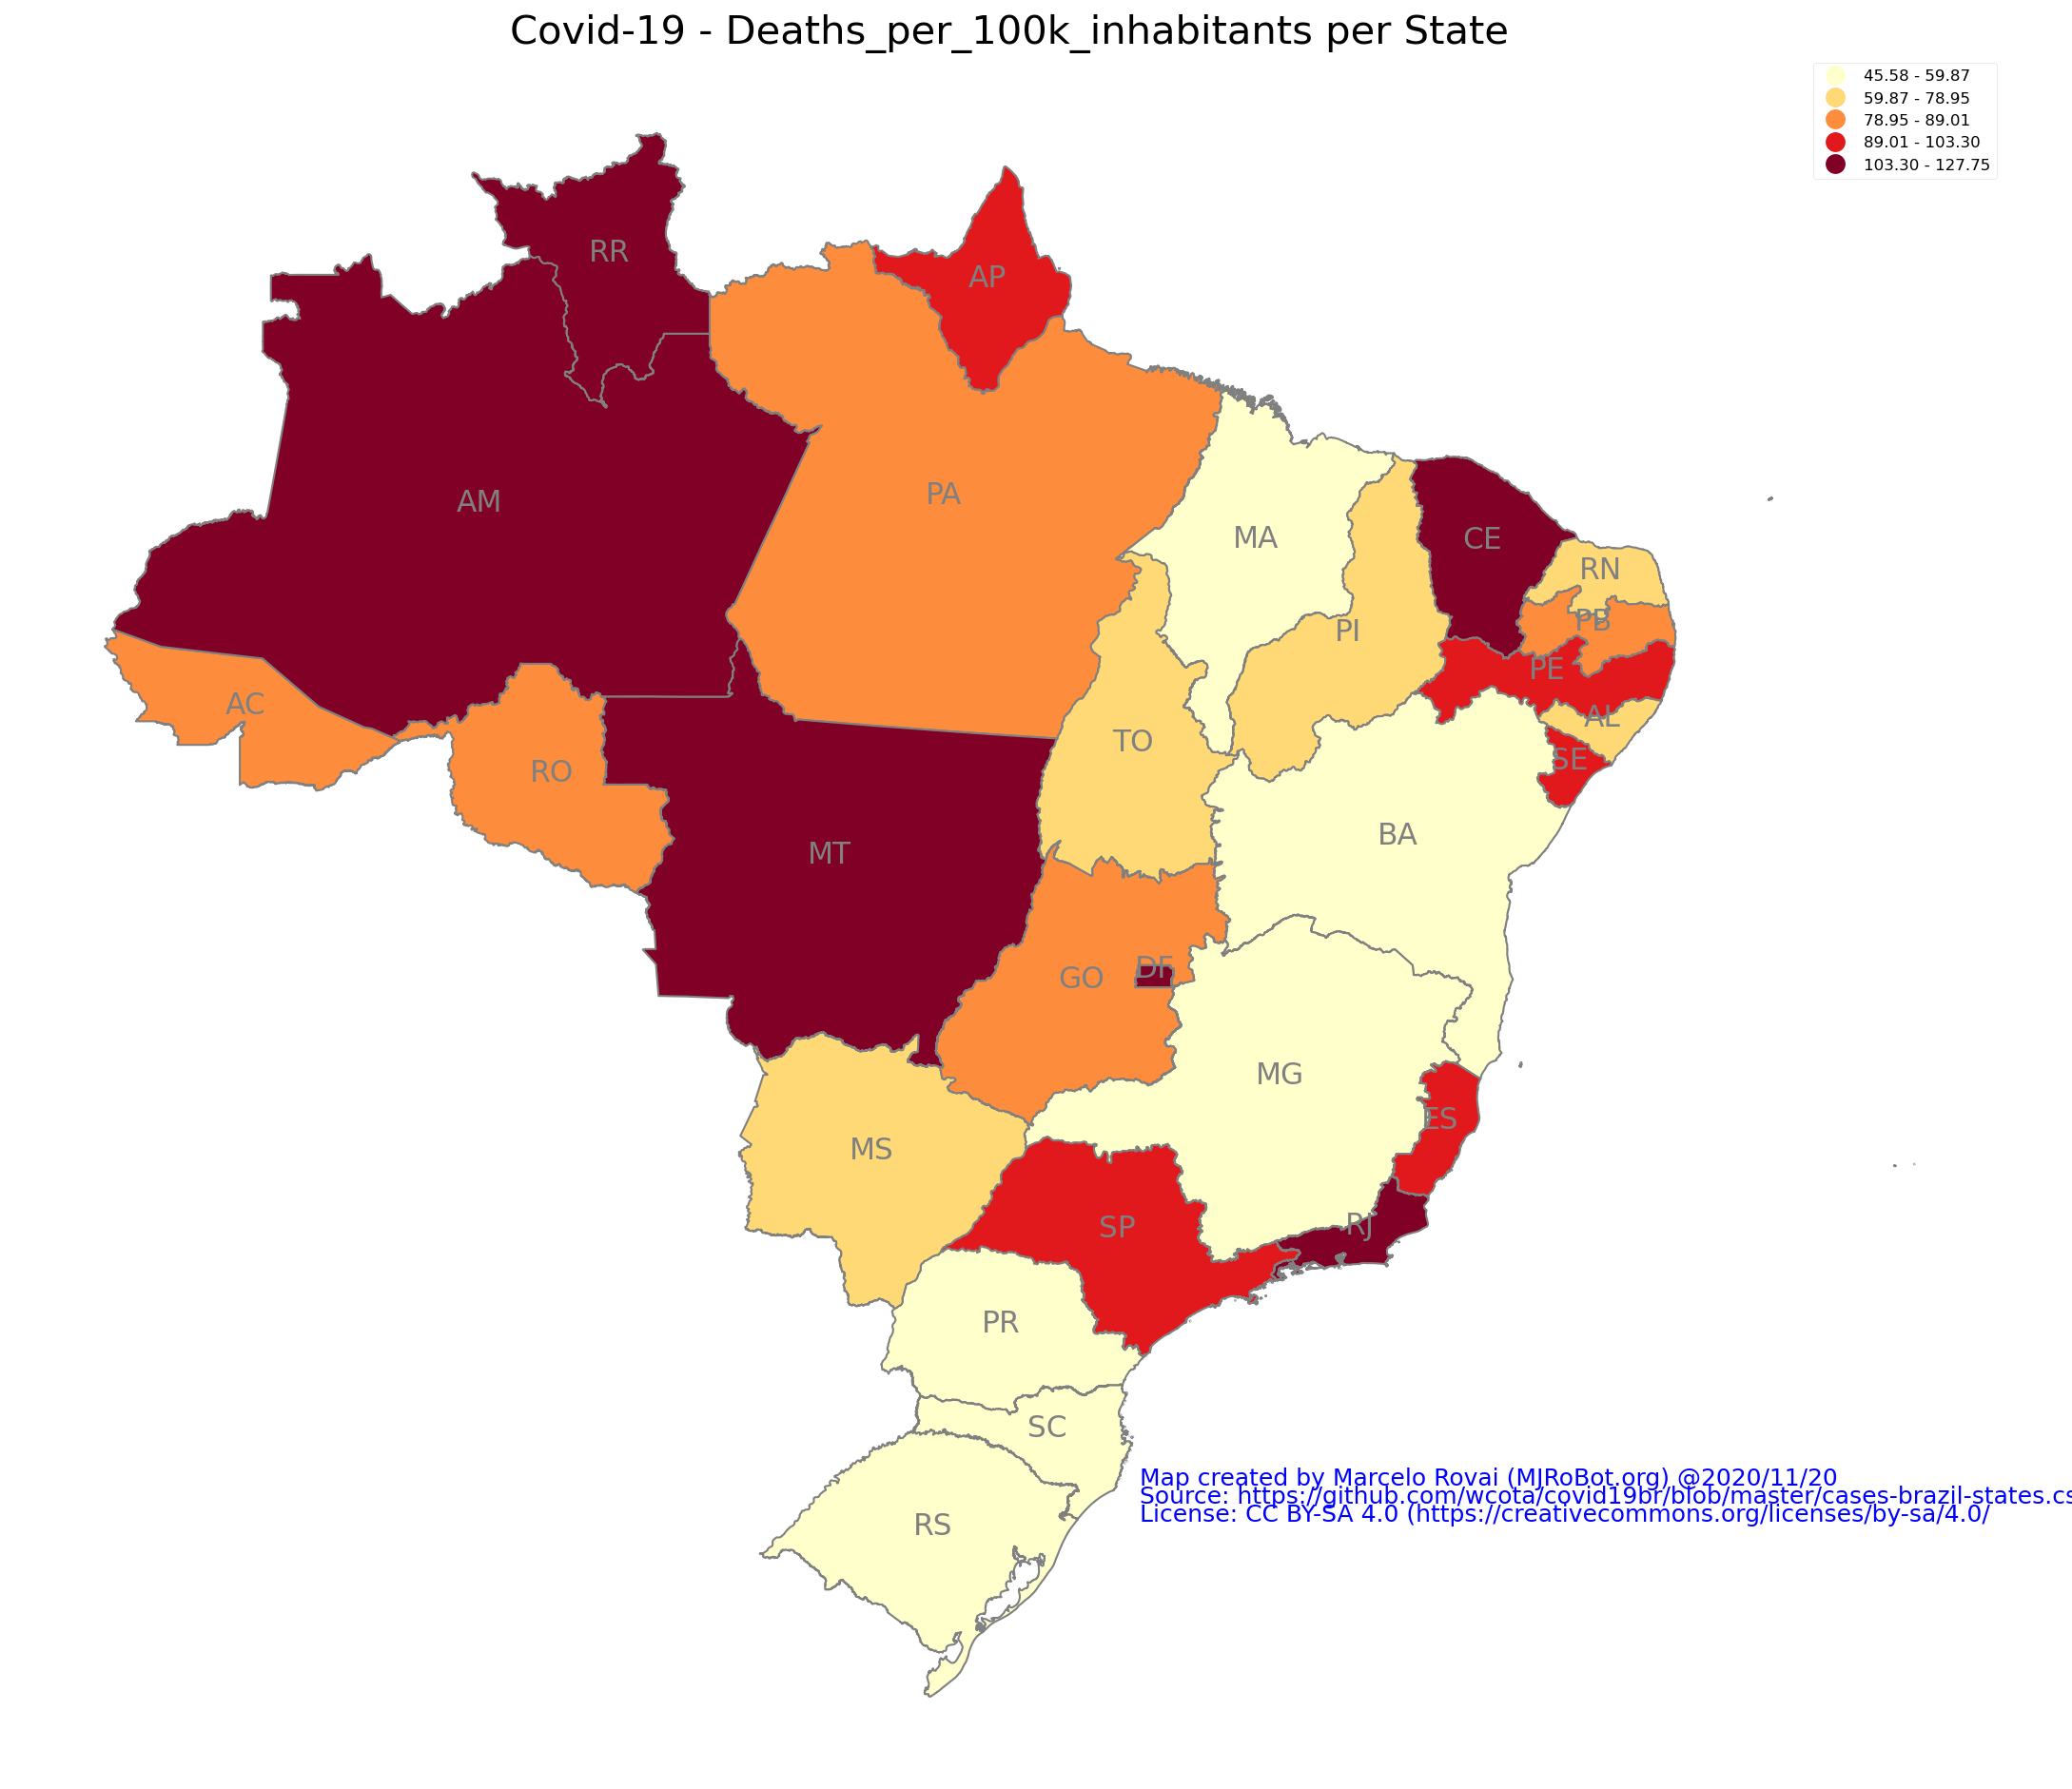

In [31]:
plot_state_map(state, 'deaths_per_100k_inhabitants')

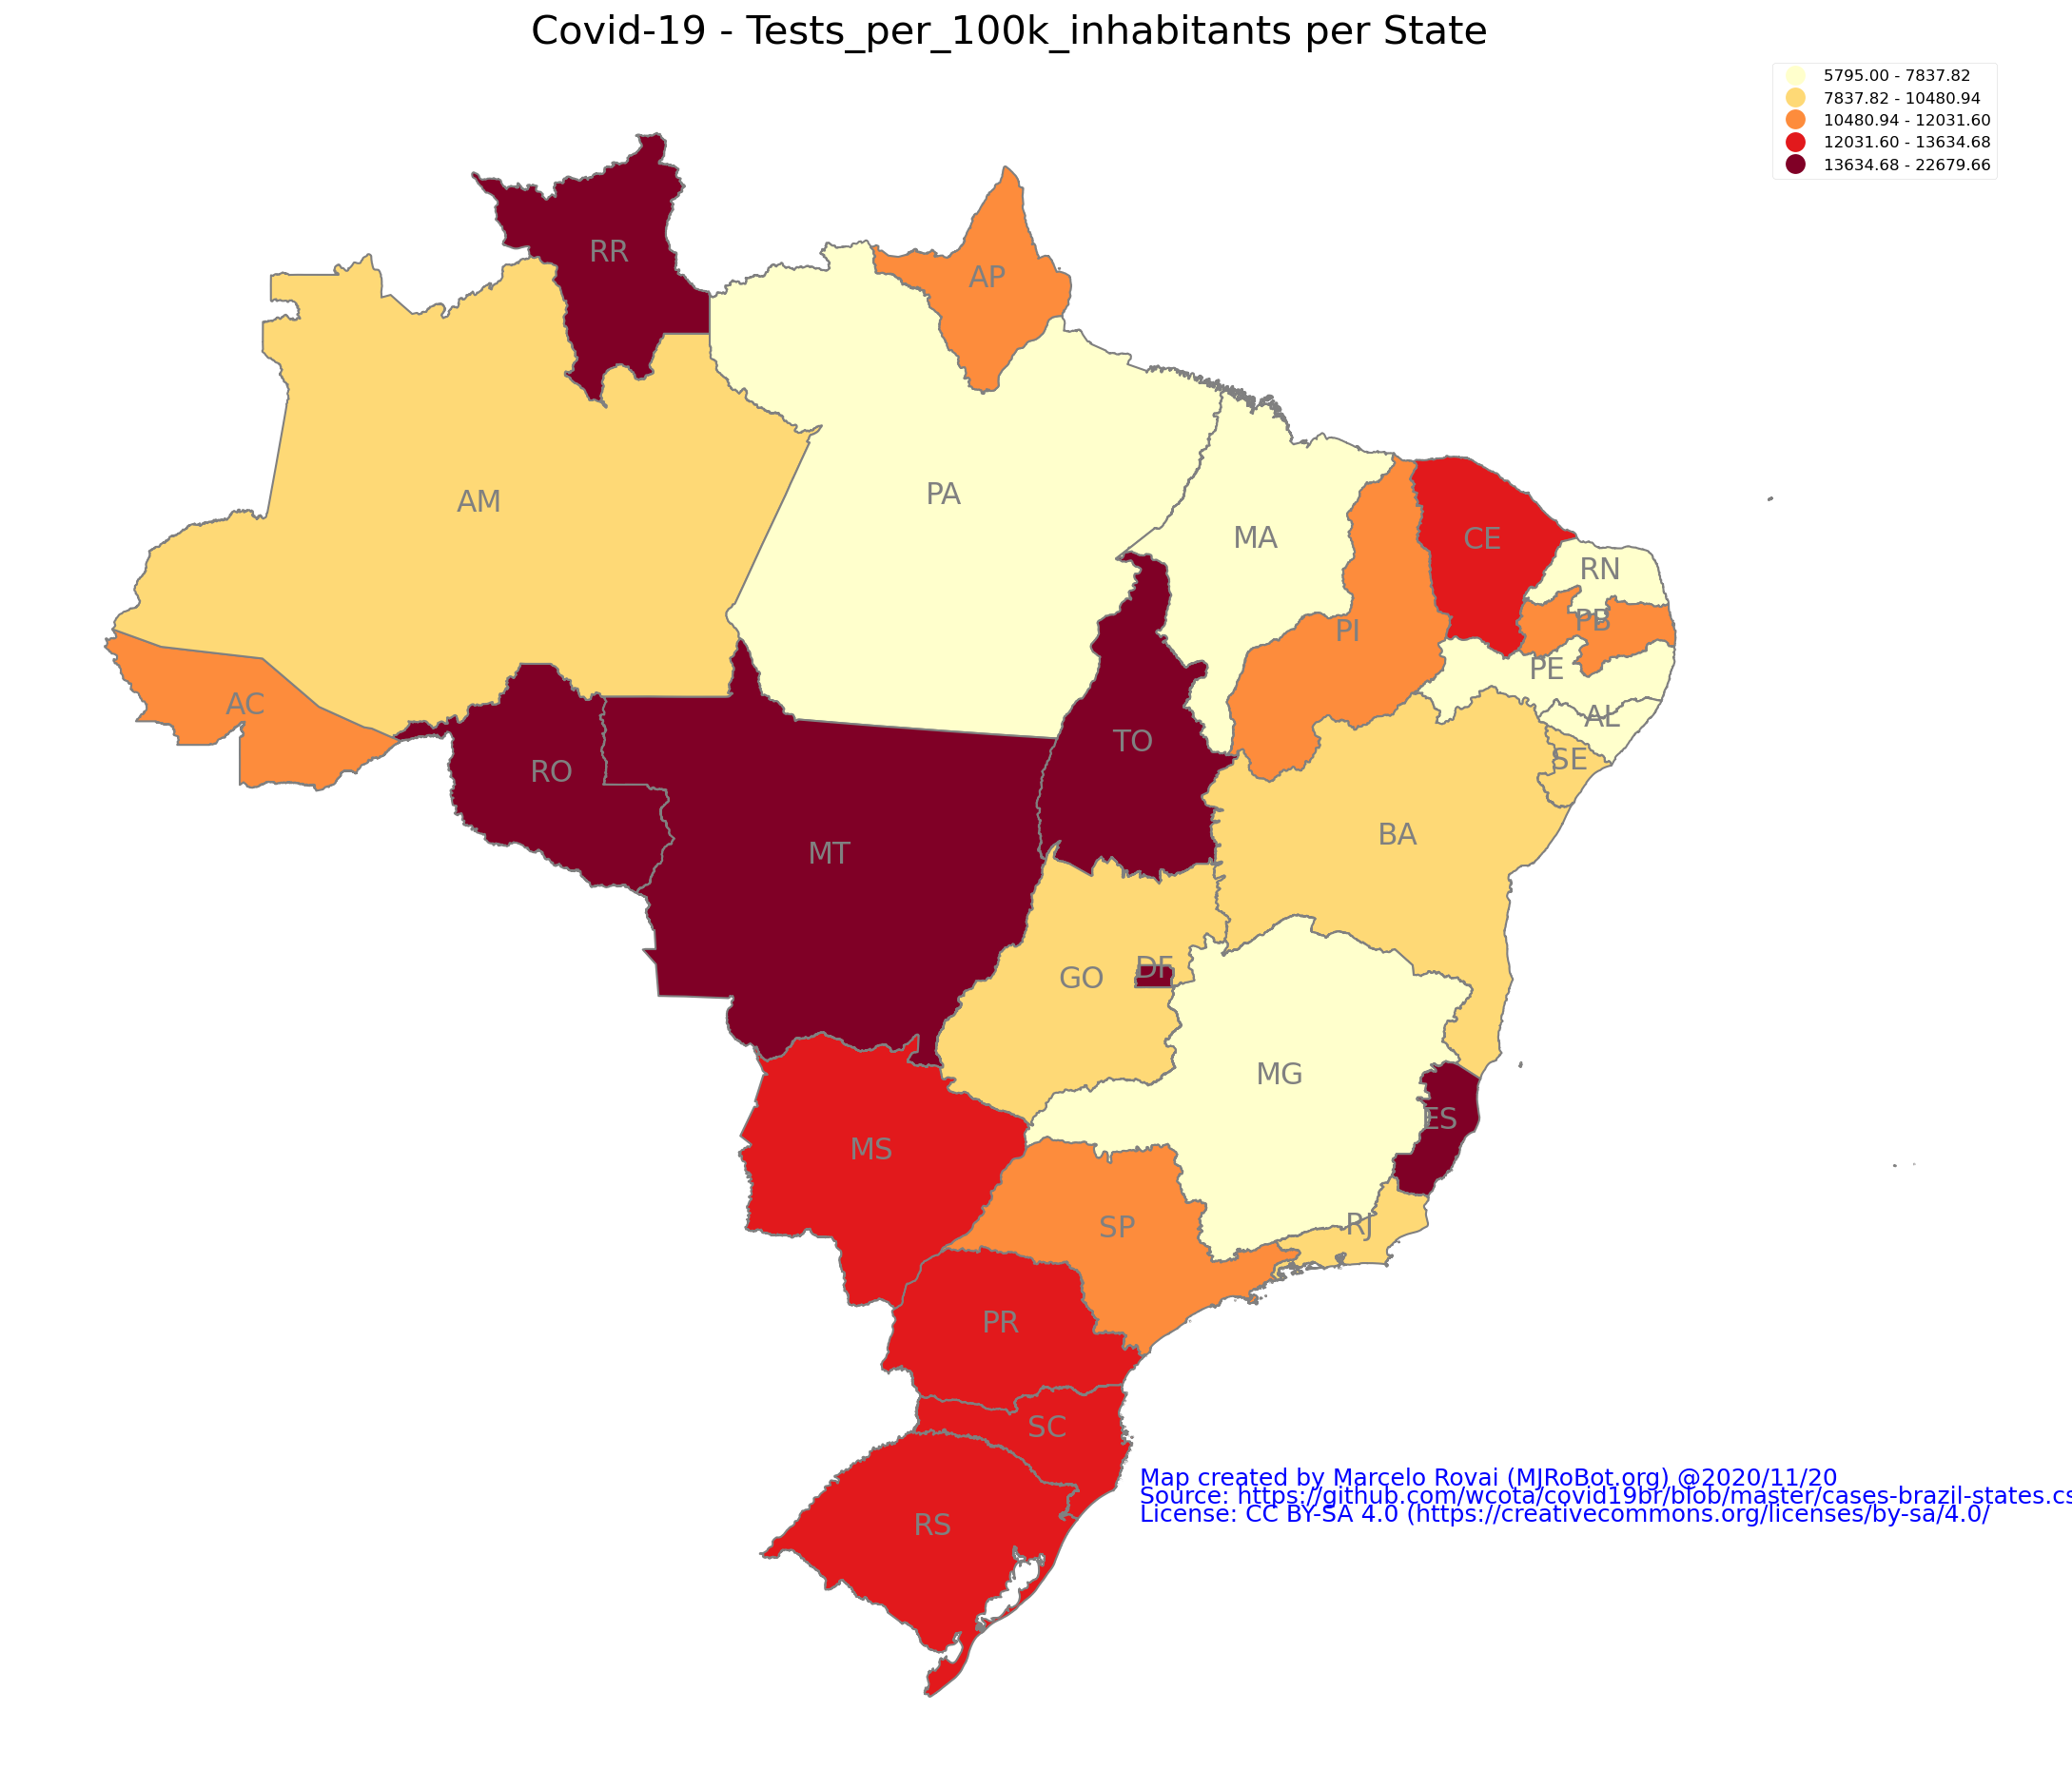

In [32]:
plot_state_map(state, 'tests_per_100k_inhabitants')

## Timelines

###  Timelines States

In [33]:
def plot_state_cases(data,
               state,
               n_0=100,
               y_scale='log',
               mov=7,
               show=False,
               save=True):
    date = datetime.datetime.today()
    data = data[data.state == state]
    tst = data[data.totalCases >= n_0]
    tst['totalCases_Mov_Ave'] = tst.iloc[:, 8].rolling(window=mov).mean()
    tst['newCases_Mov_Ave'] = tst.iloc[:,7].rolling(window=mov).mean()
    tst['deaths_Mov_Ave'] = tst.iloc[:, 6].rolling(window=mov).mean()
    tst['newDeaths_Mov_Ave'] = tst.iloc[:, 5].rolling(window=mov).mean()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tst.date, y=round(tst.totalCases_Mov_Ave), name='Total Cases', line=dict(color='royalblue', width=2)))
    fig.add_trace(go.Scatter(x=tst.date, y=round(tst.newCases_Mov_Ave), name='New Cases', line=dict(color='orange', width=2)))
    fig.add_trace(go.Scatter(x=tst.date, y=round(tst.deaths_Mov_Ave), name='Deaths', line=dict(color='firebrick', width=2)))
    fig.add_trace(go.Scatter(x=tst.date, y=round(tst.newDeaths_Mov_Ave), name='New Deaths', line=dict(color='black', width=2)))
    
    fig.update_layout(
        title='Covid-19 Brazil ({}) - {}/{}/{}'
        .format(state, date.year, date.month, date.day),
        xaxis_title="Day",
        yaxis_title="Number of Cases",
        yaxis_type=y_scale,
        font=dict(size=10, color="#7f7f7f"),
        legend=dict(x=0,
                    y=1.0,
                    bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)'),
        annotations=[
            dict(x=0,
                 y=1.05,
                 text='Cases over {:,} - Y-scale: {} ({}-day rolling avg.)'
                 .format(n_0, y_scale, mov),
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='left',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=10, color="#7f7f7f")),
            dict(x=1,
                 y=-0.10,
                 text='Source: https://github.com/wcota/covid19br/blob/master/cases-brazil-states.csv',
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue')),
            dict(x=1,
                 y=-0.14,
                 text="Created by Marcelo Rovai - https://MJRoBot.org",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue'))
        ])

    if save == True:
        fig.write_image('../graphs/cv19_' + state + '_' + y_scale +
                        '_CV_Evolution_Graph_updated.png')
    if show == True:
        fig.show()

In [34]:
def plot_state_mov_ave_deaths_last_week(data,
               state,
               n_0=100,
               y_scale='log',
               mov=7,
               show=False,
               save=True):
    date = datetime.datetime.today()
    data = data[data.state == state]
    tst = data[data.deaths >= n_0]
    tst.reset_index(drop=True, inplace = True)

    tst['new_deaths'] = tst['deaths'] - tst['deaths'].shift(1)
    tst['new_deaths_Mov_Ave'] = tst.iloc[:, -1].rolling(window=mov).mean()
    tst['mov_ave_new_deaths_last_week'] = tst['new_deaths_Mov_Ave'] - tst['new_deaths_Mov_Ave'].shift(7)
    fig = go.Figure()
    fig.add_trace(go.Bar(x=tst.date, y=round(tst.new_deaths_Mov_Ave), name='New Deaths'))
    fig.add_trace(go.Bar(x=tst.date, y=round(tst.mov_ave_new_deaths_last_week), name='New Deaths vs last week'))
    fig.update_layout(
        title='Brazil ({}) - New Deaths by Covid-19 versus same day previous week'
        .format(state),
        xaxis_title="Day",
        yaxis_title="Number of Deaths",
        yaxis_type=y_scale,
        font=dict(size=10, color="#7f7f7f"),
        legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
        annotations=[
            dict(x=0,
                 y=1.05,
                 text='Deaths over {:,} - Y-scale: {} ({}-day rolling average) - {}/{}/{}'
                 .format(n_0, y_scale, mov, date.year, date.month, date.day),
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='left',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=10, color="#7f7f7f")),
            dict(x=1,
                 y=-0.10,
                 text="Source: https://github.com/wcota/covid19br/blob/master/cases-brazil-states.csv",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue')),
            dict(x=1,
                 y=-0.14,
                 text="Created by Marcelo Rovai - https://MJRoBot.org",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue'))
        ])

    if save == True:
        fig.write_image('../graphs/cv19_' + state + '_' + y_scale +
                        '_CV_Mov_ave_deaths_last_week_Evolution_Graph_updated.png')
    if show == True:
        fig.show()

In [35]:
dt_st

epi_week        date country  state   city  newDeaths  deaths  newCases  \
0            9  2020-02-25  Brazil     SP  TOTAL          0       0         1   
1            9  2020-02-25  Brazil  TOTAL  TOTAL          0       0         1   
2            9  2020-02-26  Brazil     SP  TOTAL          0       0         0   
3            9  2020-02-26  Brazil  TOTAL  TOTAL          0       0         0   
4            9  2020-02-27  Brazil     SP  TOTAL          0       0         0   
...        ...         ...     ...    ...    ...        ...     ...       ...   
7065        47  2020-11-19  Brazil     SC  TOTAL         21    3405      4605   
7066        47  2020-11-19  Brazil     SE  TOTAL          4    2270       251   
7067        47  2020-11-19  Brazil     SP  TOTAL        147   41074      6794   
7068        47  2020-11-19  Brazil     TO  TOTAL          0    1146         0   
7069        47  2020-11-19  Brazil  TOTAL  TOTAL        626  168194     34403   

      totalCases  deathsMS  totalCasesMS  deaths_per_100k_inhabitants  \
0              1         0             0                          0.0   
1              1         0             0                          0.0   
2              1         0             1                          0.0   
3              1         0             1                          0.0   
4              1         0             1                          0.0   
...          ...       ...           ...                          ...   
7065      311393      3405        311393                     47.52409   
7066       86612      2270         86612            98.75164000000001   
7067     1191290     41074       1191290                     89.44872   
7068       78878      1146         78878                     72.86063   
7069     5985684    168061       5981767                     79.42833   

      totalCases_per_100k_inhabitants  deaths_by_totalCases  recovered  \
0                             0.00218                   0.0          0   
1              0.00047000000000000004                   0.0          0   
2                             0.00218                   0.0          0   
3              0.00047000000000000004                   0.0          0   
4                             0.00218                   0.0          0   
...                               ...                   ...        ...   
7065                       4,346.1579               0.01093     286452   
7066                      3,767.87535               0.02621      78896   
7067                      2,594.32638  0.034480000000000004    1076073   
7068                      5,014.92181  0.014530000000000001      70809   
7069                      2,826.69332                0.0281    5406066   

      suspects     tests  tests_per_100k_inhabitants  
0            0         0                         0.0  
1            0         0                         0.0  
2            0         0                         0.0  
3            0         0                         0.0  
4            0         0                         0.0  
...        ...       ...                         ...  
7065         0    925615                12,918.94471  
7066         0    201810                 8,779.32532  
7067         0   5280690                11,499.99862  
7068         0    248135         15,775.978369999999  
7069         0  22420323         10,587.825429999999  

[7070 rows x 18 columns]

In [36]:
plot_state_cases(dt_st, 'SP', y_scale='linear', n_0=1000, mov=7, show=True, save=False)
plot_state_mov_ave_deaths_last_week(dt_st, 'SP', y_scale='linear', n_0=3, mov=7, show=True, save=False)

In [37]:
plot_state_cases(dt_st, 'RJ', y_scale='linear', n_0=1000, mov=7, show=True, save=False)

In [38]:
plot_state_cases(dt_st, 'MG', y_scale='linear', n_0=1000, mov=7, show=True, save=False)

In [39]:
plot_state_cases(dt_st, 'RS', y_scale='log', n_0=1000, mov=7, show=True, save=False)

In [40]:
plot_state_cases(dt_st, 'AP', y_scale='log', n_0=1000, mov=7, show=True, save=False)
plot_state_mov_ave_deaths_last_week(dt_st, 'AP', y_scale='linear', n_0=3, mov=7, show=True, save=False)

### Timeline Brazil

In [108]:
plot_cases(dt_tm, 'TOTAL', y_scale='linear', n_0=1000, mov=7, show=True, save=False)

In [83]:
plot_cases(dt_tm, 'TOTAL', y_scale='log', n_0=1000, mov=7, show=True, save=False)

### Timeline of cases per city**

In [43]:
top_cities = list(dt.sort_values('totalCases', ascending=False)[:10].city)
top_cities

['São Paulo/SP',
 'Brasília/DF',
 'Rio de Janeiro/RJ',
 'Salvador/BA',
 'Goiânia/GO',
 'Manaus/AM',
 'Fortaleza/CE',
 'Belo Horizonte/MG',
 'Belém/PA',
 'Porto Alegre/RS']

In [44]:
top_cities_deaths = list(dt.sort_values('deaths', ascending=False)[:15].city)
top_cities_deaths

['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Fortaleza/CE',
 'Brasília/DF',
 'Manaus/AM',
 'Salvador/BA',
 'Recife/PE',
 'Belém/PA',
 'Goiânia/GO',
 'Belo Horizonte/MG',
 'Guarulhos/SP',
 'Curitiba/PR',
 'Porto Alegre/RS',
 'Campinas/SP',
 'São Luís/MA']

In [109]:
for city in top_cities:
    plot_cases(dt_tm, city, y_scale='linear', n_0=100, mov=7, show=True, save=False)
    plot_cases(dt_tm, city, y_scale='log', n_0=100, mov=7, show=True, save=False) 
    plot_mov_ave_deaths_last_week(dt_tm, city, y_scale='linear', n_0=3, mov=7, show=True, save=False)

### Specific cities analisis 

In [46]:
city = "Itajaí/SC"
plot_cases(dt_tm, city, y_scale='linear', n_0=100, mov=7, show=True, save=False)
plot_cases(dt_tm, city, y_scale='log', n_0=100, mov=7, show=True, save=False) 
plot_mov_ave_deaths_last_week(dt_tm, city, y_scale='linear', n_0=3, mov=7, show=True, save=False)

In [47]:
city = "Duque de Caxias/RJ"
plot_cases(dt_tm, city, y_scale='linear', n_0=100, mov=7, show=True, save=False)
plot_cases(dt_tm, city, y_scale='log', n_0=100, mov=7, show=True, save=False) 
plot_mov_ave_deaths_last_week(dt_tm, city, y_scale='linear', n_0=3, mov=7, show=True, save=False)

## Timeline New Deaths versus Previus Week 

In [89]:
def plot_mov_ave_deaths_last_week_2(data,
                                  city,
                                  n_0=100,
                                  y_scale='log',
                                  mov=7,
                                  graph='bar',
                                  show=False,
                                  save=True,
                                  rect=False,
                                  x0=None,
                                  x1=None,
                                  text=None):
    date = datetime.datetime.today()
    data = data[data.city == city]
    tst = data[data.deaths >= n_0]
    tst.reset_index(drop=True, inplace=True)

    tst['new_deaths'] = tst['deaths'] - tst['deaths'].shift(1)
    tst['new_deaths_Mov_Ave'] = tst.iloc[:, -1].rolling(window=mov).mean()
    tst['mov_ave_new_deaths_last_week'] = tst['new_deaths_Mov_Ave'] - tst[
        'new_deaths_Mov_Ave'].shift(7)
    fig = go.Figure()
    if graph == 'bar':
        fig.add_trace(
            go.Bar(x=tst.date,
                   y=round(tst.new_deaths_Mov_Ave),
                   name='New daily deaths'))
        fig.add_trace(
            go.Bar(x=tst.date,
                   y=round(tst.mov_ave_new_deaths_last_week),
                   name='New daily deaths vs last week'))
    else:
        fig.add_trace(
            go.Scatter(x=tst.date,
                       y=round(tst.new_deaths_Mov_Ave),
                       name='New daily Deaths',
                       line=dict(color='royalblue', width=2)))
        fig.add_trace(
            go.Scatter(x=tst.date,
                       y=round(tst.mov_ave_new_deaths_last_week),
                       name='New daily deaths vs last week',
                       line=dict(color='firebrick', width=2)))
    if rect == True:
        fig.update_layout(
            shapes=[
                # 1st highlight during Feb 4 - Feb 6
                dict(
                    type="rect",
                    # x-reference is assigned to the x-values
                    xref="x",
                    # y-reference is assigned to the plot paper [0,1]
                    yref="paper",
                    x0=x0,
                    y0=0,
                    x1=x1,
                    y1=1,
                    fillcolor="LightSalmon",
                    opacity=0.3,
                    layer="below",
                    line_width=0,
                )
            ],
            annotations=[
                dict(x=x0,
                     y=0.8,
                     xref="x",
                     yref='paper',
                     text=text,
                     showarrow=True,
                     font=dict(family="Courier New, monospace",
                               size=16,
                               color="#ffffff"),
                     align="center",
                     arrowhead=2,
                     arrowsize=1,
                     arrowwidth=2,
                     arrowcolor="#636363",
                     ax=20,
                     ay=-30,
                     bordercolor="#c7c7c7",
                     borderwidth=2,
                     borderpad=4,
                     bgcolor="#ff7f0e",
                     opacity=0.5)
            ])

    fig.update_layout(
        title='Brazil ({}) - New Daily Deaths by Covid-19 versus same day previous week'.
        format(city),
        xaxis_title="Day",
        yaxis_title="Number of Deaths",
        yaxis_type=y_scale,
        font=dict(size=10, color="#7f7f7f"),
        legend=dict(x=0,
                    y=1.0,
                    bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)'),
        annotations=[
            dict(
                x=0,
                y=1.05,
                text='Deaths over {:,} - Y-scale: {} ({}-day rolling average) - {}/{}/{}'
                .format(n_0, y_scale, mov, date.year, date.month, date.day),
                showarrow=False,
                xref='paper',
                yref='paper',
                xanchor='left',
                yanchor='auto',
                xshift=0,
                yshift=0,
                font=dict(size=10, color="#7f7f7f")),
            dict(
                x=0,
                y=1.05,
                text='Deaths over {:,} - Y-scale: {} ({}-day rolling average) - {}/{}/{}'
                .format(n_0, y_scale, mov, date.year, date.month, date.day),
                showarrow=False,
                xref='paper',
                yref='paper',
                xanchor='left',
                yanchor='auto',
                xshift=0,
                yshift=0,
                font=dict(size=10, color="#7f7f7f")),
            dict(x=1,
                 y=-0.10,
                 text="Source: Brasil.io - https://brasil.io/dataset/covid19/caso/",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue')),
            dict(x=1,
                 y=-0.14,
                 text="Created by Marcelo Rovai - https://MJRoBot.org",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue'))
        ])

    if save == True:
        city = city.replace('/', '-')
        fig.write_image(
            '../graphs/cv19_' + city + '_' + graph +'_' + y_scale +
            '_CV_Mov_ave_deaths_last_week_Evolution_Graph_updated.png')
    if show == True:
        fig.show()

    return tst

In [49]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Fortaleza/CE',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=True, 
                                    x0='2020-05-07',
                                    x1='2020-05-31',
                                    text="Lock-Down")

In [50]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'São Paulo/SP',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=True, 
                                    x0='2020-05-20',
                                    x1='2020-05-25',
                                    text="Holidays")

In [51]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Recife/PE',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=True, 
                                    x0='2020-05-16',
                                    x1='2020-05-31',
                                    text="Lock-Down")

In [52]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Rio de Janeiro/RJ',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [53]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Manaus/AM',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [54]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Porto Velho/RO',
                                    y_scale='linear',
                                    n_0=1,
                                    mov=3,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [55]:
plot_cases(dt_tm, 'Porto Velho/RO', y_scale='log', n_0=100, mov=7, show=True, save=False)

In [56]:
plot_cases(dt_tm, 'Porto Velho/RO', y_scale='log', n_0=100, mov=7, show=True, save=False)

In [57]:
plot_cases(dt_tm, 'Belo Horizonte/MG', y_scale='log', n_0=100, mov=7, show=True, save=False)

In [58]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Belo Horizonte/MG',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [59]:
plot_cases(dt_tm, 'Brasília/DF', y_scale='log', n_0=1000, mov=7, show=True, save=False)

In [60]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Brasília/DF',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [61]:
plot_cases(dt_tm, 'São Paulo/SP', y_scale='log', n_0=1000, mov=7, show=True, save=False)

In [110]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'São Paulo/SP',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [63]:
plot_cases(dt_tm, 'Salvador/BA', y_scale='log', n_0=1000, mov=7, show=True, save=False)

In [64]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Salvador/BA',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=14,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [90]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'TOTAL',
                                    y_scale='linear',
                                    n_0=50_000,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [66]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Brasília/DF',
                                    y_scale='linear',
                                    n_0=1,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [67]:
tst[tst.date == '2020-05-08']

epi_week        date country state         city   ibgeID  \
40        19  2020-05-08  Brazil    DF  Brasília/DF  5300108   

    cod_RegiaoDeSaude name_RegiaoDeSaude  newDeaths  deaths  newCases  \
40           53,001.0   Distrito Federal          2      37       184   

    totalCases  deaths_per_100k_inhabitants  totalCases_per_100k_inhabitants  \
40        2442                      1.21107                         79.93064   

    deaths_by_totalCases _source last_info_date  new_deaths  \
40               0.01515     SES     2020-11-18         2.0   

    new_deaths_Mov_Ave  mov_ave_new_deaths_last_week  
40  0.8571428571428571            0.1428571428571428

# Other Graphics

## Multiple Cities

In [68]:
def get_dataframe(df, cities, feature, rnd=0, in_data='2020-04-01', mov=1, cmp_lst_week=False):
    data_city = pd.DataFrame(df.date)
    for city in cities:
        df_city = round(df[df.city == city][feature], rnd)
        data_city[city] = df_city
    data_city = data_city.fillna(0)
    #data_city = data_city[data_city.date > in_data]
    data_city = data_city.groupby('date').agg(np.sum)
    
    tst = data_city.copy()
    tst = round(tst.iloc[:].rolling(window=mov).mean(), 0)
    if cmp_lst_week:
        tst = tst - tst.shift(7)
    tst = tst[tst.index > in_data]
    return tst

In [69]:
def plot_cities(df, cities, feature, mov, title, order=4):
    dx = get_dataframe(df, cities, feature, mov)
    dx = dx.reset_index()
    fig = plt.figure(figsize=(15, 8))
    for city in cities:
        sns.regplot(x=dx.index, y=city, data=dx, scatter=False, order=order)
    plt.legend(labels=cities, loc='upper left')
    plt.title("Covid19 - {}: {} ({}-day rolling average - fit curve order {})".
              format(title, feature, mov, order),
              size=16)
    plt.xlabel('Days', size=12)
    plt.ylabel(feature, size=12)

In [70]:
top_cities_deaths = list(dt.sort_values('deaths', ascending=False)[:10].city)
top_cities_deaths

['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Fortaleza/CE',
 'Brasília/DF',
 'Manaus/AM',
 'Salvador/BA',
 'Recife/PE',
 'Belém/PA',
 'Goiânia/GO',
 'Belo Horizonte/MG']

In [71]:
capital_cities = ['Belém/PA', 
'Fortaleza/CE',
'Recife/PE',
'Manaus/AM',
'Rio de Janeiro/RJ',
'São Luís/MA',
'São Paulo/SP',
'Maceió/AL',
'Rio Branco/AC',
'Vitória/ES',
'Macapá/AP',
'Boa Vista/RR',
'Porto Velho/RO',
'João Pessoa/PB',
'Salvador/BA',
'Natal/RN',
'Teresina/PI',
'Aracaju/SE',
'Brasília/DF',
'Goiânia/GO',
'Porto Alegre/RS',
'Cuiabá/MT',
'Curitiba/PR',
'Palmas/TO',
'Belo Horizonte/MG',
'Florianópolis/SC',
'Campo Grande/MS']

In [72]:
N_capital_cities = [
'Belém/PA', 
'Manaus/AM',
'Rio Branco/AC',
'Macapá/AP',
'Boa Vista/RR',
'Porto Velho/RO',
]

In [73]:
NE_capital_cities = [
'Fortaleza/CE',
'Recife/PE',
'São Luís/MA',
'Maceió/AL',
'João Pessoa/PB',
'Salvador/BA',
'Natal/RN',
'Teresina/PI',
'Aracaju/SE',
]

In [74]:
SE_capital_cities = [
'Rio de Janeiro/RJ',
'São Paulo/SP',
'Vitória/ES',
'Belo Horizonte/MG',
]

In [75]:
S_CO_capital_cities = [
'Brasília/DF',
'Goiânia/GO',
'Porto Alegre/RS',
'Cuiabá/MT',
'Curitiba/PR',
'Palmas/TO',
'Belo Horizonte/MG',
'Florianópolis/SC',
'Campo Grande/MS'
]

In [76]:
select_cities = ['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Fortaleza/CE',
 'Belém/PA',
 'Recife/PE',
 'Manaus/AM',
 'Salvador/BA',
 'São Luís/MA',
 'Curitiba/PR',
 'Brasília/DF']

In [77]:
dt_tm.columns

Index(['epi_week', 'date', 'country', 'state', 'city', 'ibgeID',
       'cod_RegiaoDeSaude', 'name_RegiaoDeSaude', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deaths_per_100k_inhabitants',
       'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', '_source',
       'last_info_date'],
      dtype='object')

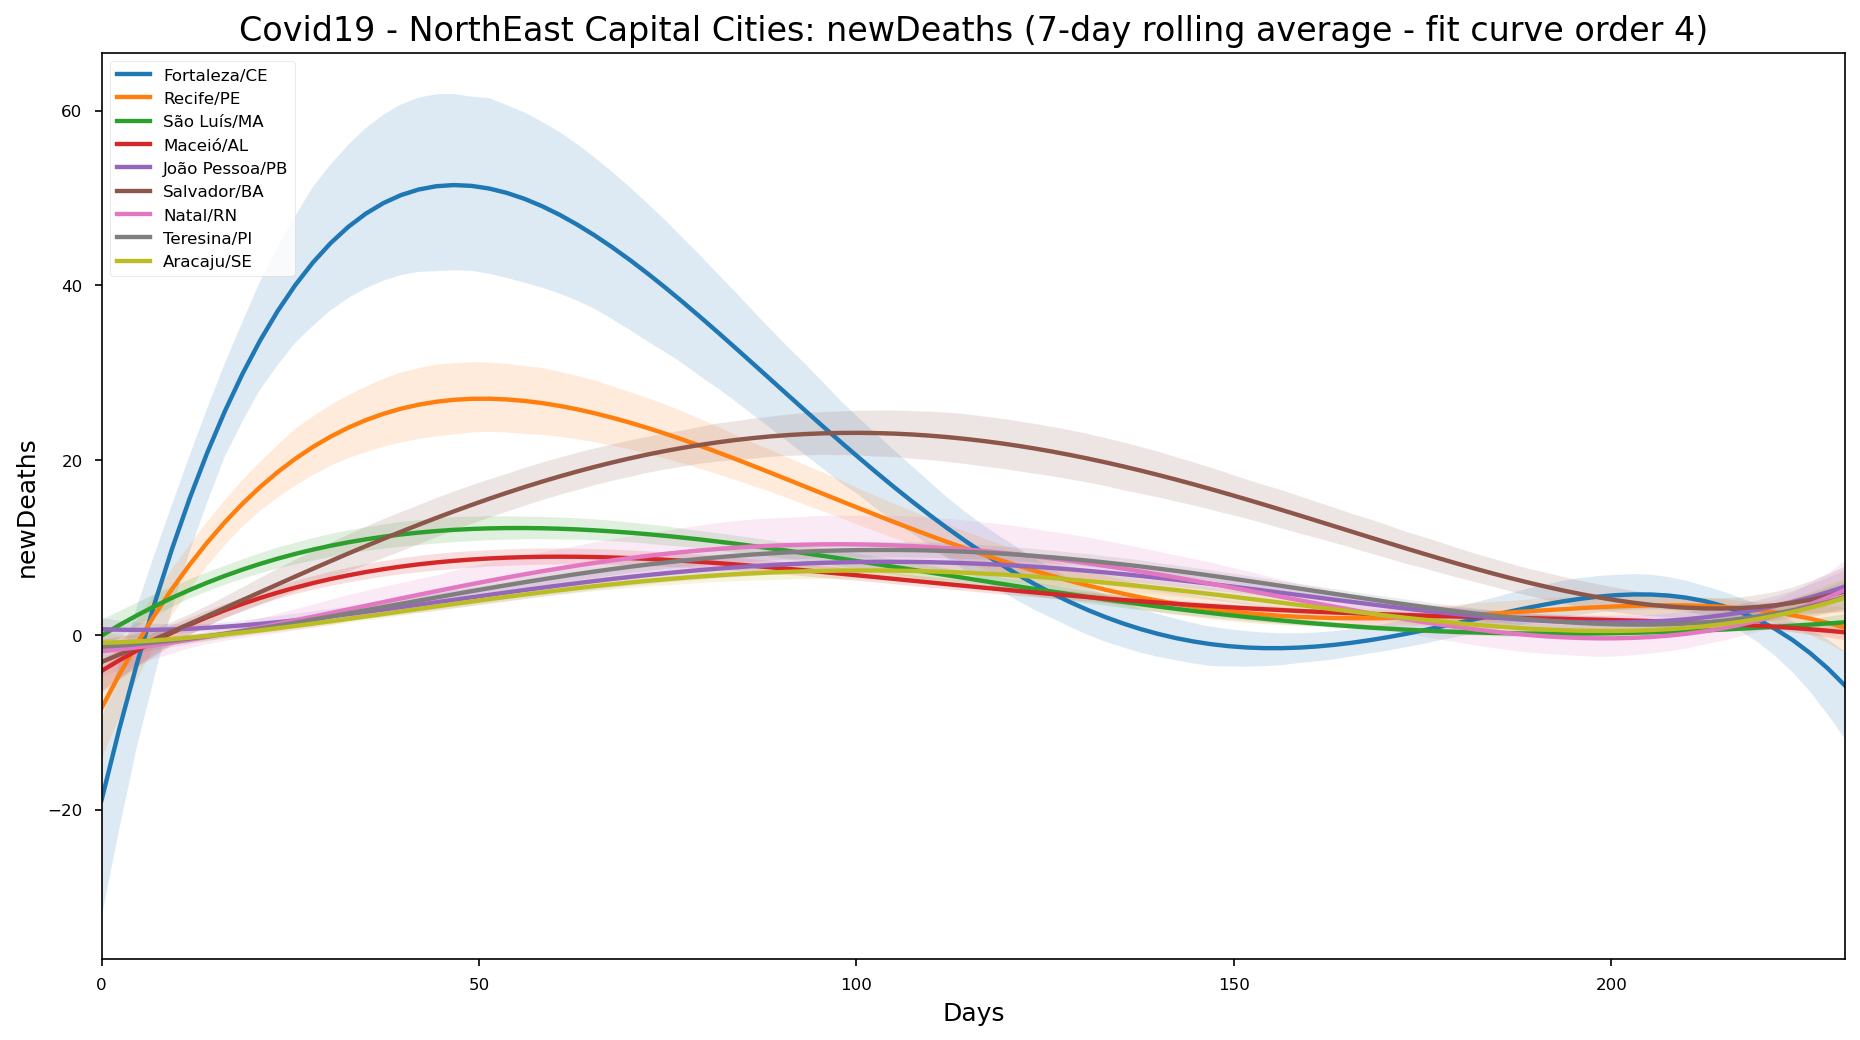

In [78]:
dx = plot_cities(dt_tm, NE_capital_cities, feature = 'newDeaths', title = 'NorthEast Capital Cities', mov=7, order=4)

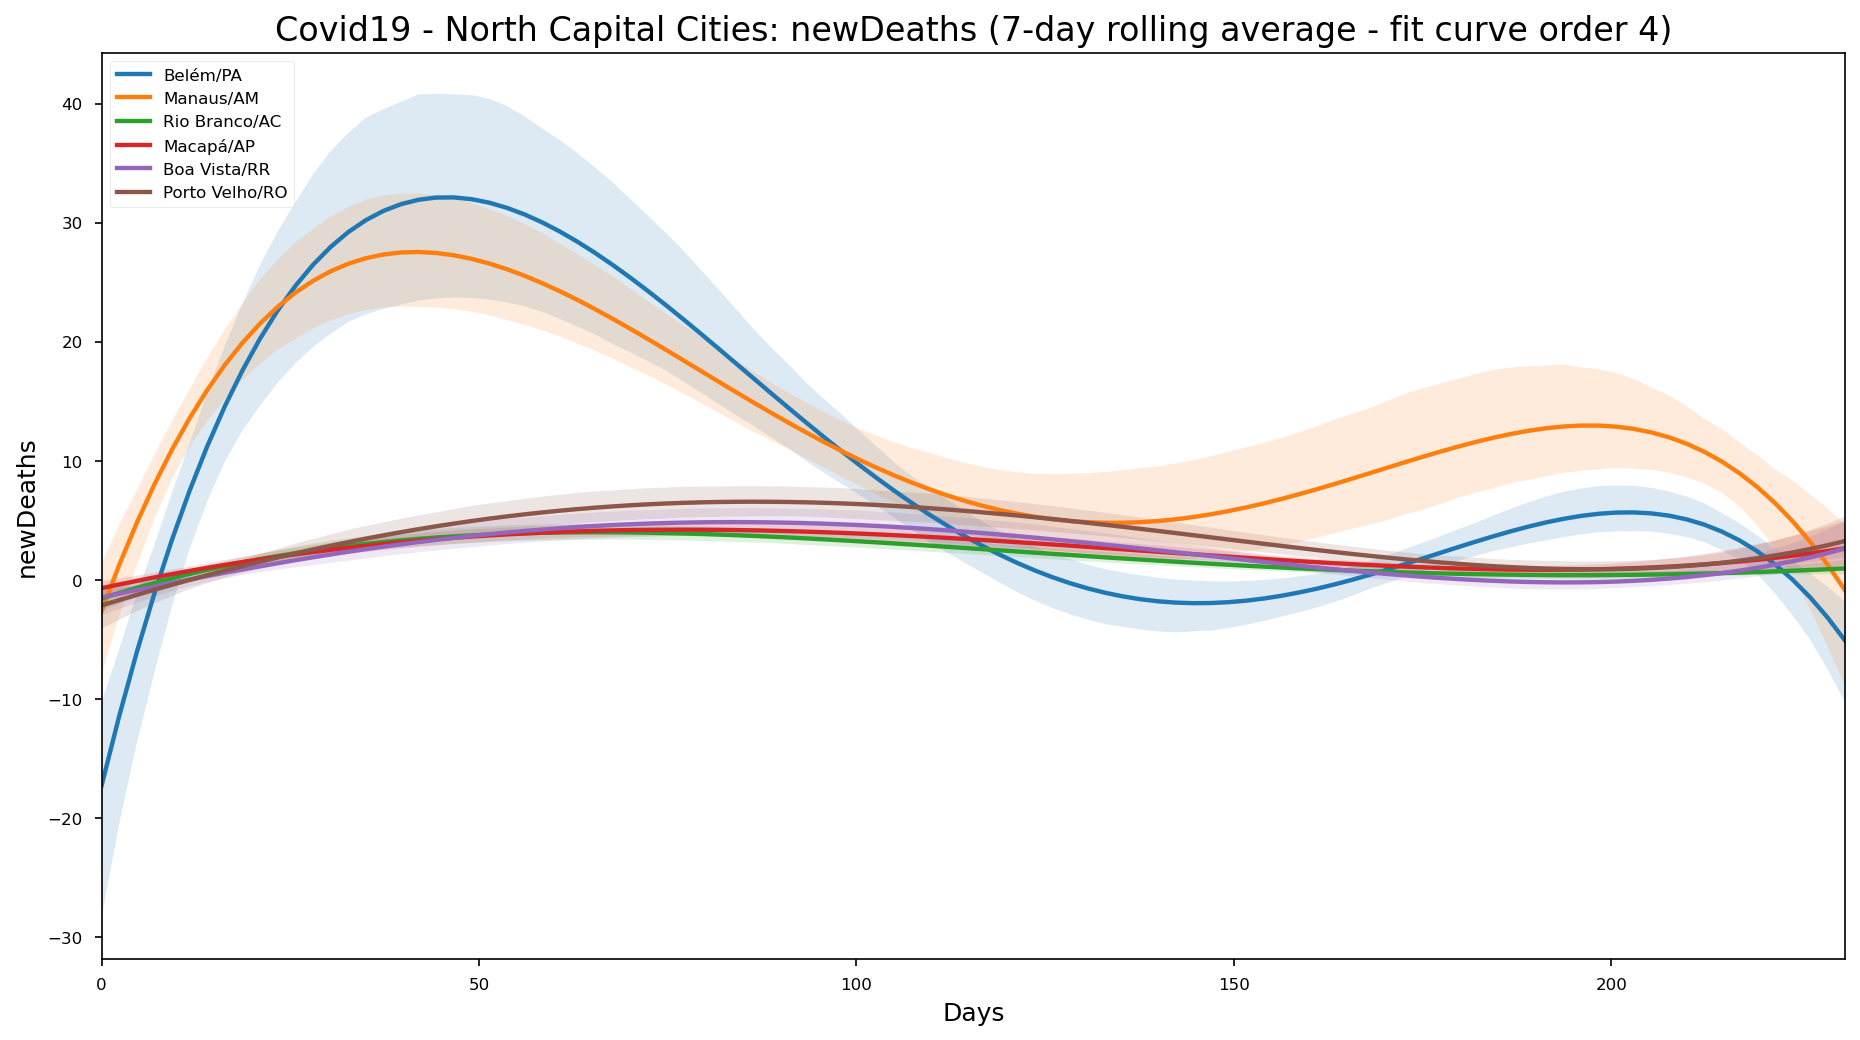

In [79]:
dx = plot_cities(dt_tm, N_capital_cities, feature = 'newDeaths', title = 'North Capital Cities', mov=7, order=4)

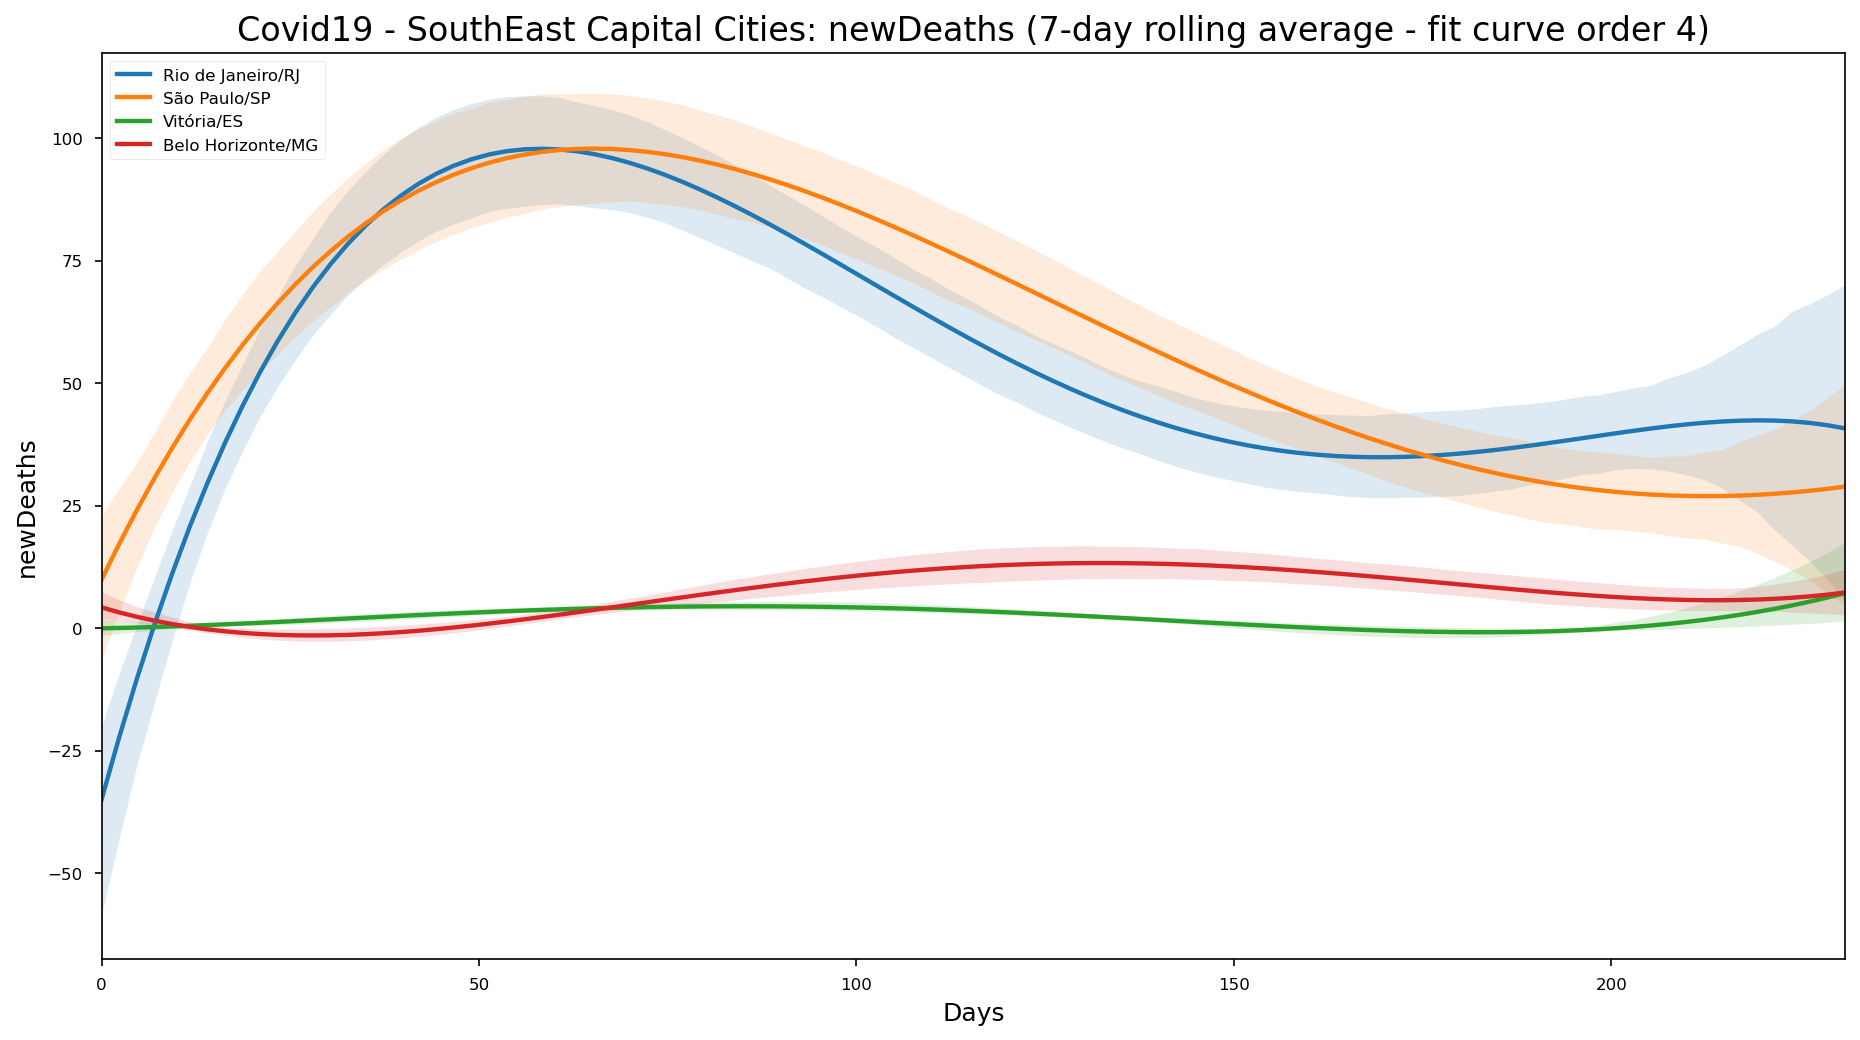

In [80]:
dx = plot_cities(dt_tm, SE_capital_cities, feature = 'newDeaths', title = 'SouthEast Capital Cities', mov=7, order=4)

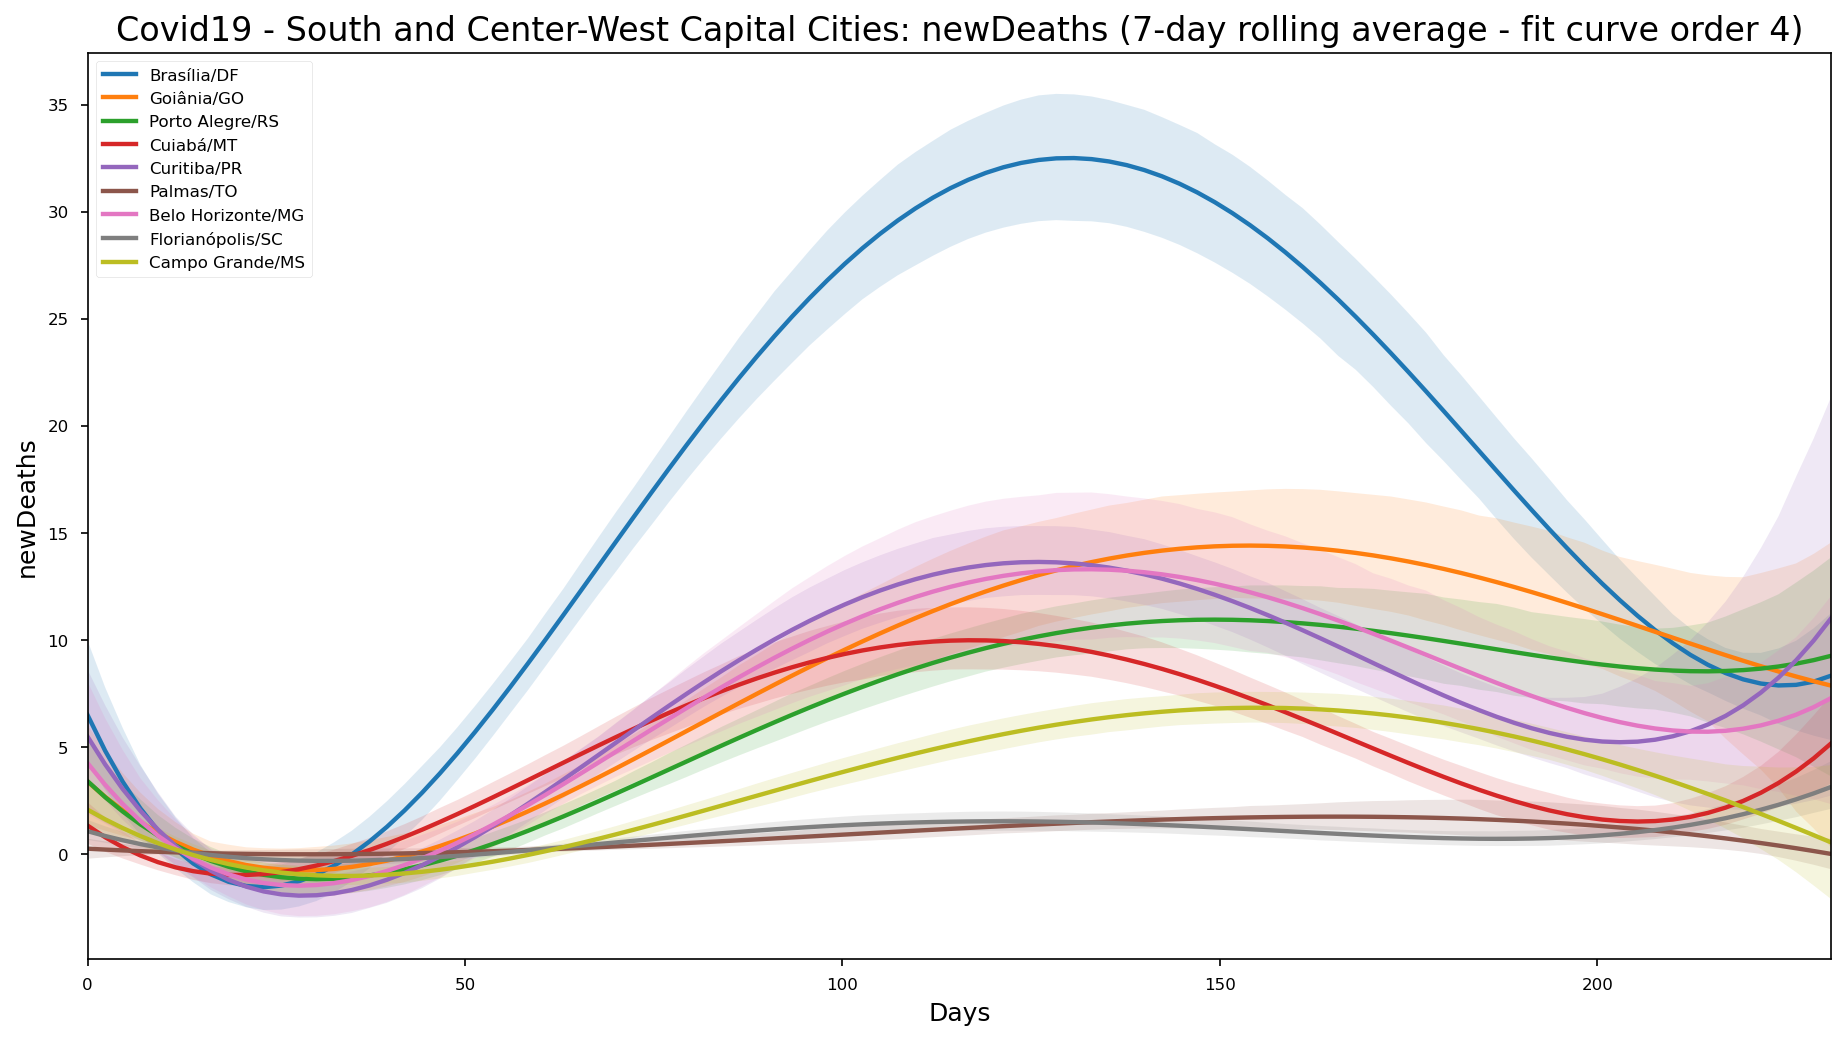

In [81]:
dx = plot_cities(dt_tm, S_CO_capital_cities, feature = 'newDeaths', title = 'South and Center-West Capital Cities', mov=7, order=4)

## Bar Race

In [82]:
bcr.bar_chart_race(dead_city, 
                   title='Brazil Top Cities with COVID-19 cases - Deaths per 100K inhabitants',
                   filename=None)

NameError: name 'dead_city' is not defined

In [ ]:
bcr.bar_chart_race(dead_city, 
                   title='Brazil Top Cities with COVID-19 cases - Deaths per 100K inhabitants',
                  filename='../videos/top_cities_deaths_100K.mp4')

In [ ]:
br_capital_cities = ['Belém', 
'Fortaleza',
'Recife',
'Manaus',
'Rio de Janeiro',
'São Luís',
'São Paulo',
'Maceió',
'Rio Branco',
'Vitória',
'Macapá',
'Boa Vista',
'Porto Velho',
'João Pessoa',
'Salvador',
'Natal',
'Teresina',
'Aracaju',
'Brasília',
'Goiânia',
'Porto Alegre',
'Cuiabá',
'Curitiba',
'Palmas',
'Belo Horizonte',
'Florianópolis',
'Campo Grande']

In [ ]:
capital_cities = ['Belém/PA', 
'Fortaleza/CE',
'Recife/PE',
'Manaus/AM',
'Rio de Janeiro/RJ',
'São Luís/MA',
'São Paulo/SP',
'Maceió/AL',
'Rio Branco/AC',
'Vitória/ES',
'Macapá/AP',
'Boa Vista/RR',
'Porto Velho/RO',
'João Pessoa/PB',
'Salvador/BA',
'Natal/RN',
'Teresina/PI',
'Aracaju/SE',
'Brasília/DF',
'Goiânia/GO',
'Porto Alegre/RS',
'Cuiabá/MT',
'Curitiba/PR',
'Palmas/TO',
'Belo Horizonte/MG',
'Florianópolis/SC',
'Campo Grande/MS']

In [ ]:
dead_capital = get_dataframe(df=dt_tm,
                          cities=capital_cities,
                          feature='deaths_per_100k_inhabitants',
                          rnd=0,
                          in_data='2020-03-20')

In [ ]:
dead_capital

In [ ]:
bcr.bar_chart_race(dead_capital, 
                   title='Brazil Capital Cities - COVID-19 - Deaths per 100K inhabitants',
                   filename=None)

In [ ]:
bcr.bar_chart_race(dead_capital, 
                   title='Brazil Capital Cities - COVID-19 - Deaths per 100K inhabitants',
                  filename='../videos/capital_cities_deaths_100K.mp4')

In [ ]:
top_cities_deaths

In [ ]:
dead_top_city = get_dataframe(df=dt_tm,
                          cities=top_cities_deaths,
                          feature='deaths_per_100k_inhabitants',
                          rnd=0,
                          in_data='2020-03-20')

In [ ]:
bcr.bar_chart_race(dead_top_city, 
                   title='Brazil Top Cities - COVID-19 - Deaths per 100K inhabitants',
                   filename=None)

In [ ]:
bcr.bar_chart_race(dead_top_city, 
                   title='Brazil Top Cities - COVID-19 - Deaths per 100K inhabitants',
                  filename='../videos/top_death_cities_deaths_100K.mp4')

# SRAG - FioCruz

In [ ]:
url = 'https://gitlab.procc.fiocruz.br/mave/repo/-/raw/master/Dados/InfoGripe/serie_temporal_com_estimativas_recentes.csv'

In [ ]:
srag = pd.read_csv(url, sep=';')
srag.shape

In [ ]:
srag.head()

In [ ]:
srag.info()

In [ ]:
srag['Unidade da Federação'].value_counts()

In [ ]:
srag.dado.value_counts()

In [ ]:
srag['Total reportado até a última atualização'] = srag['Total reportado até a última atualização'].

In [ ]:
srag_mg = srag[srag['Unidade da Federação'] == 'Minas Gerais']

In [ ]:
srag_mg.head()